In [1]:
"--- LIBRARIES ---"
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold
from PIL import Image
import random
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter("ignore")
import os
import shutil
from PIL import ImageFile
from classification_models.keras import Classifiers #For zoo library of ResNet18

Preprocessing Operations


In [2]:
#Preparing folders for getting data Afterwards
root_path=""
data_name=os.path.join(root_path,"data")
source_file=[]
classes=["cats","dogs"]
X=[]
Y=[]
training_dir=os.path.join(data_name,"training_set")
test_dir=os.path.join(data_name,"test_set")
validation_dir=os.path.join(data_name ,"validation")
validation_cats_dir=os.path.join(validation_dir, "cats")
validation_dogs_dir=os.path.join(validation_dir, "dogs")
#Preparing Validation File for once
"""
os.makedirs(validation_dir)
os.makedirs(validation_cats_dir)
os.makedirs(validation_dogs_dir)
"""

'\nos.makedirs(validation_dir)\nos.makedirs(validation_cats_dir)\nos.makedirs(validation_dogs_dir)\n'

In [3]:
#Defined some functions for transfering data between folders, (Specially for validation-to-train and train-to-validation in KFOLD implementation)
def transfer_between_folders(source, dest, split_rate):
    global source_files
    source_files = os.listdir(source)
    if(len(source_files) != 0):
        transfer_file_numbers = int(len(source_files)*split_rate)
        transfer_index = random.sample(
            range(0, len(source_files)), transfer_file_numbers)
        for each_index in transfer_index:
            shutil.move(os.path.join(source, str(source_files[each_index])), os.path.join(
                dest, str(source_files[each_index])))
    else:
        print("No file moved. Source is empty!")


def transfer_classes_between_folder(source, dest, split_rate):
    for label in classes:
        transfer_between_folders(os.path.join(data_name, source, label),
                                 os.path.join(
                                     data_name, dest, label),
                                 split_rate)
#Function for defining and finding metrics of the model.
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    f1_Score = f1_score(y_true, y_pred, average='weighted')
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1_Score))
   
    return accuracy, precision, f1_Score


In [4]:

def prepare_name_with_labels(folder_name, dataset_type='training_set'):

    source_files = os.listdir(os.path.join(data_name, dataset_type, folder_name))
    y_label = 0
    for i in range(len(classes)):
        if(folder_name == classes[i]):
            y_label = i
    for val in source_files:
        X.append(val)
        Y.append(y_label)

In [5]:
# Organizing the  file names and class labels in X and Y variables
for i in range(len(classes)):
    prepare_name_with_labels(classes[i])

X = np.asarray(X)
Y = np.asarray(Y)

Kfold Definitions

In [6]:
#KFOLD definitions , 5folds as defined in project document.
from sklearn.model_selection import KFold
kf=KFold(n_splits=5,shuffle=True)
kf.get_n_splits(X,Y)



5

General Implementation Function

In [7]:
#General implementation function , takes models as parameters and applies 5 fold to those models through the data which processed in "ImageDataGenerator" for every fold.
def implementationwith5FOLD(modell):
    fold_num=0
    #Definitions of list for getting wanted results.
    models=[]
    acc=[]
    val_acc=[]
    test_acc=[]
    cm=[]
    for train_index, val_index in kf.split(X, Y):
        fold_num += 1
        print("Results for fold", fold_num)
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        # Moving validation images of this fold from train folder to the validation folder
        transfer_classes_between_folder('validation', 'training_set', 1.0)
        for each_index in range(len(X_val)):
            class_label = ''
            for i in range(len(classes)):
                if(Y_val[each_index] == i):
                    class_label = classes[i]
                # Then, copy the validation images to the validation folder
            shutil.move(os.path.join(data_name, 'training_set', class_label, X_val[each_index]),
                        os.path.join(data_name, 'validation', class_label, X_val[each_index]))
        #Data preparing process
        train_datagen = ImageDataGenerator( rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)
        train_generator=train_datagen.flow_from_directory(directory=training_dir,
                                                        batch_size=64,
                                                        class_mode="binary",
                                                        shuffle=True,
                                                        target_size=(200,200))
        val_generator=val_datagen.flow_from_directory(directory=validation_dir,
                                                    batch_size=64,
                                                    class_mode="binary",
                                                    shuffle=True,
                                                    target_size=(200,200))
        test_generator = test_datagen.flow_from_directory(test_dir,
                                                            target_size=(200,200),
                                                            batch_size=64,
                                                            class_mode="binary",
                                                            shuffle=False)   
        #Fitting to the model                                         
        history=modell.fit(train_generator,
                            epochs=15,
                            validation_data=val_generator)
        #Getting validation images back to the training file.
        transfer_classes_between_folder('validation', 'training_set', 1.0)                    
        predictions = modell.predict(test_generator, verbose=1)
        y_predictions = [1 * (x[0]>=0.5) for x in predictions]
        true_classes = test_generator.classes
        test_accu, test_prec, test_fScore = metrics(true_classes, y_predictions) 
        test_acc.append(test_accu) 
        cm.append(confusion_matrix(true_classes,y_predictions))
        models.append([modell,history])
    #Getting average "accuracy" and "validation accuracy" values.
    for i in range(5):
        accEpoch=models[i][1].history["accuracy"]
        val_acc_epoch=models[i][1].history["val_accuracy"]
        acc.append(accEpoch[14])
        val_acc.append(val_acc_epoch[14])
        
    test_accuracy=np.asarray(test_acc).mean()
    print("Average accuracy for model: ",np.asarray(acc).mean())
    print("Average val_accuracy for model: ",np.asarray(val_acc).mean())
    print("Test accuracy for the model:",test_accuracy)
    
    
    
    
    
    return models, test_acc,cm, predictions
        

Definitions of Models with "Adam" Optimizer and "Binary CrossEntropy" loss

Model 1 = 2 Convolution Layers and 2 Fully Connected Layers 

In [8]:
#Fırst Model = 2 Convolution Layers and 2 Fully Connected Layers with free choose of activation functions
def model1():
    model=tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(200,200,3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="binary_crossentropy",
                  metrics=["accuracy",tf.keras.metrics.AUC(name="auc")])
    return model

model1=model1()

2023-01-09 19:43:52.381129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:43:52.411802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:43:52.411960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:43:52.412506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model 2 with full of sigmoid activation functions (5 Conv Layers and 2 Dense Layers)

In [9]:
#Model2= 5 Convolutional Layers and 2 Fully Connected Layers with only "sigmoid" activation function with Adam optimizer and "binary_crossentropy" loss.
def model2():
  model=tf.keras.Sequential([
      tf.keras.layers.Conv2D(32,(3,3),activation="sigmoid",input_shape=(200,200,3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128,(3,3),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256,(2,2),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(512,(2,2),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256,activation="sigmoid"),
      tf.keras.layers.Dense(1,activation="sigmoid"),
      
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy",tf.keras.metrics.AUC(name="auc")])
  return model

model2=model2()

MODEL3 (5 CONV LAYERS AND 2 FULLY CONNECTED LAYERS)

In [10]:
#Model3= 5 Convolutional Layers and 2 Fully Connected Layers with free choose of activation functions with Adam optimizer and "binary_crossentropy" loss.
def model3():
    model=tf.keras.Sequential([
      tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(200,200,3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256,(2,2),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(512,(2,2),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256,activation="relu"),
      tf.keras.layers.Dense(1,activation="sigmoid"),
      
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy",tf.keras.metrics.AUC(name="auc")])
    return model
model3=model3()

RESNET18

In [11]:
#Model4= ResNet18 with Adam optimizer and "binary_crossentropy" loss.
from classification_models.keras import Classifiers
def model4():
    # for tensorflow.keras
    # from classification_models.tfkeras import Classifiers

    ResNet18, preprocess_input = Classifiers.get('resnet18')
    n_classes = 1

    base_model = ResNet18(input_shape=(200,200,3), include_top=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(n_classes, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss="binary_crossentropy",
                 metrics=["accuracy"])
    model.summary()
    return model
model4=model4()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 200, 200, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 100, 100, 64  9408        ['zero_padding2d[0][0]']   

Running the Models and Getting the results and PLOTS

MODEL1 , Adam(),BinaryCrossentropy

In [12]:
m1models,m1test_acc,m1_cm,m1_pred=implementationwith5FOLD(model1)

Results for fold 1
Found 1344 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15


2023-01-09 19:36:29.289827: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-01-09 19:36:30.363146: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-09 19:36:30.723663: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


21/21 [==============================] - 6s 110ms/step - loss: 11.7747 - accuracy: 0.5744 - auc: 0.5950 - val_loss: 1.4055 - val_accuracy: 0.5352 - val_auc: 0.5898
Epoch 2/15
21/21 [==============================] - 2s 98ms/step - loss: 5.0066 - accuracy: 0.7307 - auc: 0.7695 - val_loss: 0.7563 - val_accuracy: 0.5625 - val_auc: 0.5801
Epoch 3/15
21/21 [==============================] - 2s 106ms/step - loss: 2.5496 - accuracy: 0.8207 - auc: 0.8640 - val_loss: 0.9256 - val_accuracy: 0.5000 - val_auc: 0.5432
Epoch 4/15
21/21 [==============================] - 2s 113ms/step - loss: 1.3283 - accuracy: 0.8772 - auc: 0.9202 - val_loss: 2.1280 - val_accuracy: 0.5000 - val_auc: 0.4713
Epoch 5/15
21/21 [==============================] - 2s 97ms/step - loss: 0.5343 - accuracy: 0.9301 - auc: 0.9647 - val_loss: 1.2730 - val_accuracy: 0.5000 - val_auc: 0.5917
Epoch 6/15
21/21 [==============================] - 2s 104ms/step - loss: 0.2292 - accuracy: 0.9561 - auc: 0.9862 - val_loss: 2.5187 - val_acc

In [13]:
#Accuracies on test set
m1test_acc

[0.535, 0.6525, 0.6425, 0.6575, 0.6475]

Plotting the loss and accuracy graphs for model1 with Adam() and BinaryCrossentropy loss


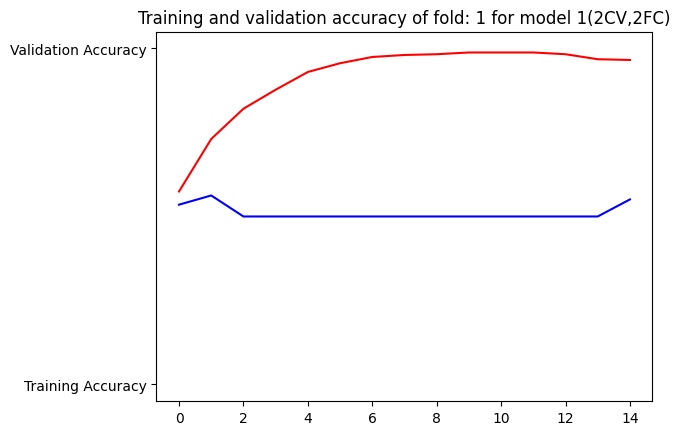

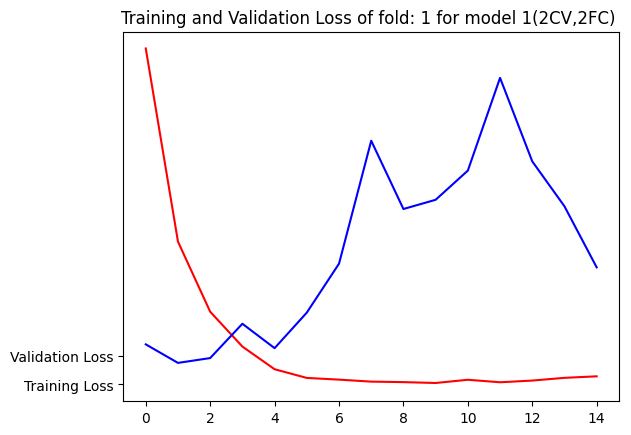

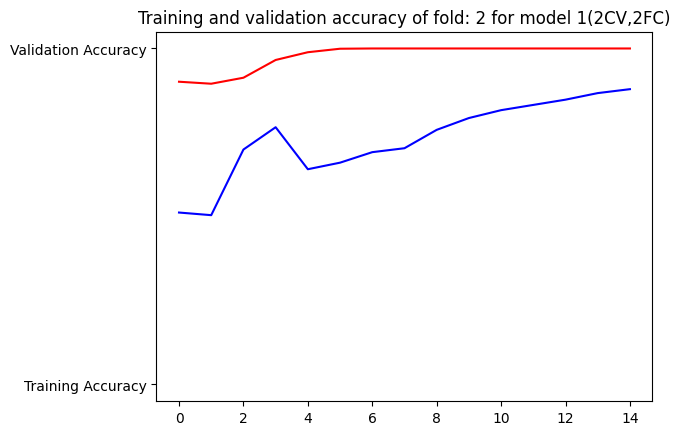

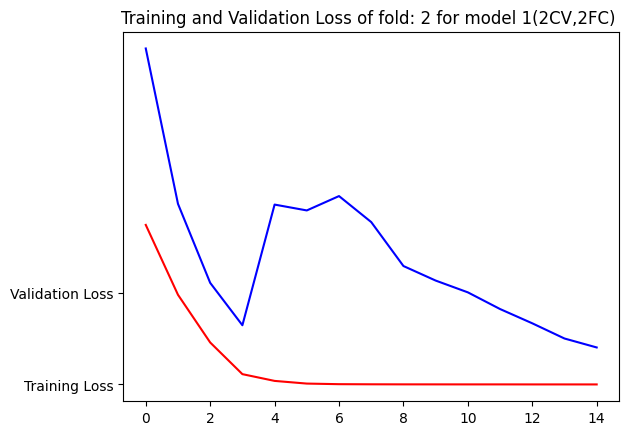

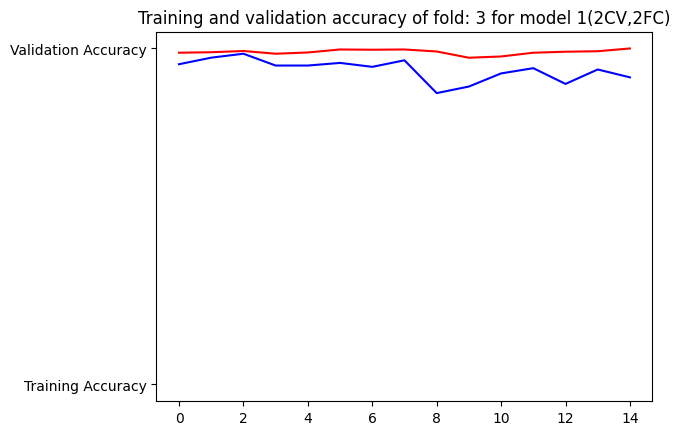

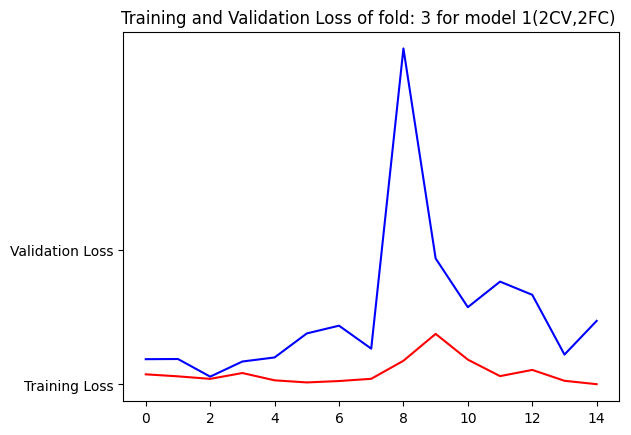

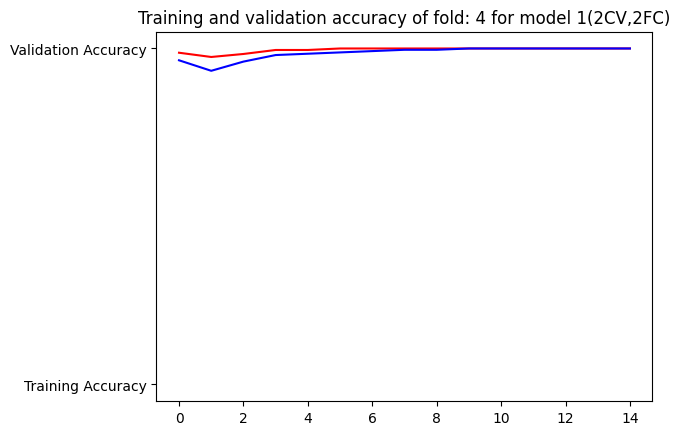

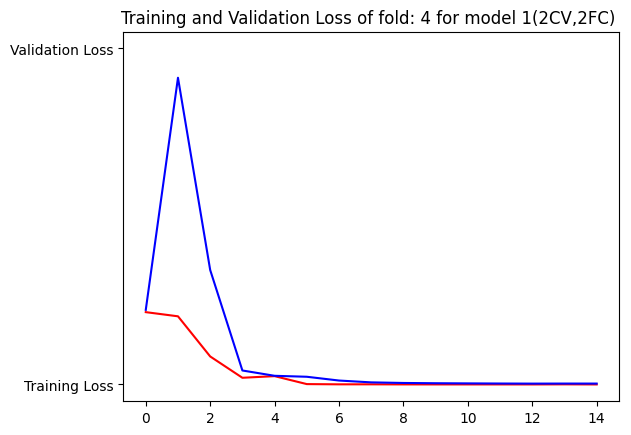

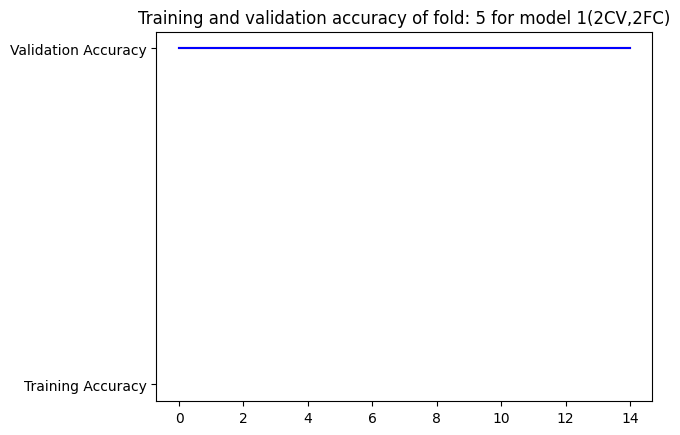

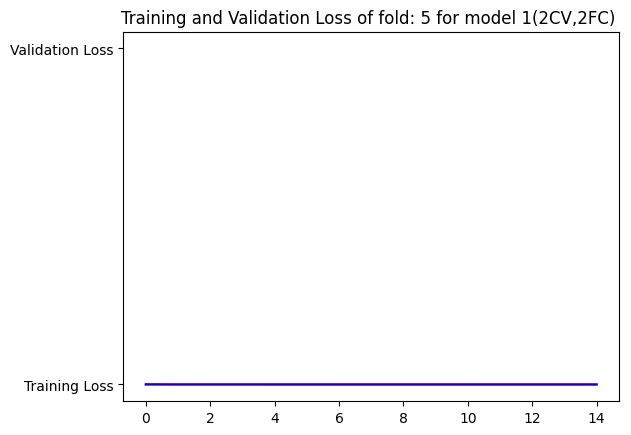

In [14]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for model1 with Adam() and BinaryCrossentropy loss")
for i in range(5):
    loss=m1models[i][1].history["loss"]
    val_loss=m1models[i][1].history["val_loss"]
    acc=m1models[i][1].history['accuracy']
    val_acc=m1models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 1(2CV,2FC)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 1(2CV,2FC) ")
    plt.show()

MODEL 2 , Adam(),BinaryCrossentropy

In [15]:
m2models,m2test_acc,m2_cm,m2_pred=implementationwith5FOLD(model2)

Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1344 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15
21/21 [==============================] - 5s 155ms/step - loss: 0.8912 - accuracy: 0.6109 - auc: 0.6367 - val_loss: 0.9741 - val_accuracy: 0.5352 - val_auc: 0.5074
Epoch 2/15
21/21 [==============================] - 3s 143ms/step - loss: 0.5998 - accuracy: 0.6719 - auc: 0.7405 - val_loss: 1.2958 - val_accuracy: 0.5352 - val_auc: 0.5154
Epoch 3/15
21/21 [==============================] - 3s 144ms/step - loss: 0.5185 - accuracy: 0.7381 - auc: 0.8186 - val_loss: 1.3343 - val_accuracy: 0.5352 - val_auc: 0.5274
Epoch 4/15
21/21 [==============================] - 3s 144ms/step - loss: 0.4688 - accuracy: 0.7798 - auc: 0.8654 - val_loss: 1.2744 - val_accuracy: 0.5352 - val_auc: 0.5574
Epoch 5/15
21/21 [==============================] - 3s 143ms/step - loss: 0.4364 - accuracy: 0.8058 - a

In [ ]:
m2test_acc


[0.5, 0.5, 0.505, 0.665, 0.7425]

Plotting the loss and accuracy graphs for model2 with Adam() and BinaryCrossentropy loss


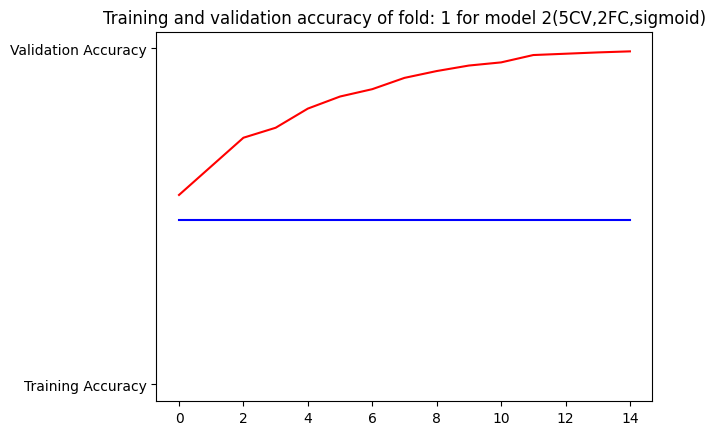

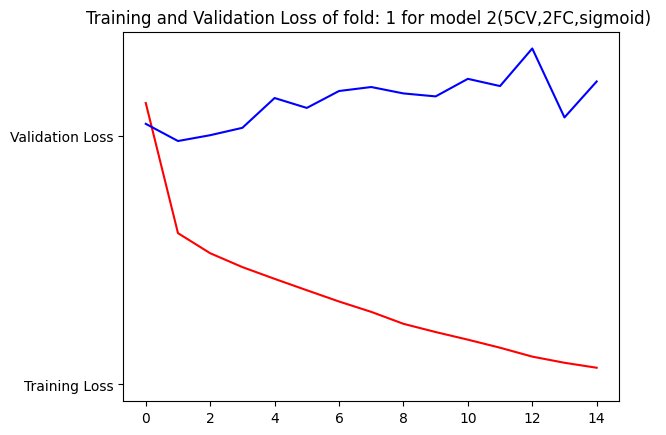

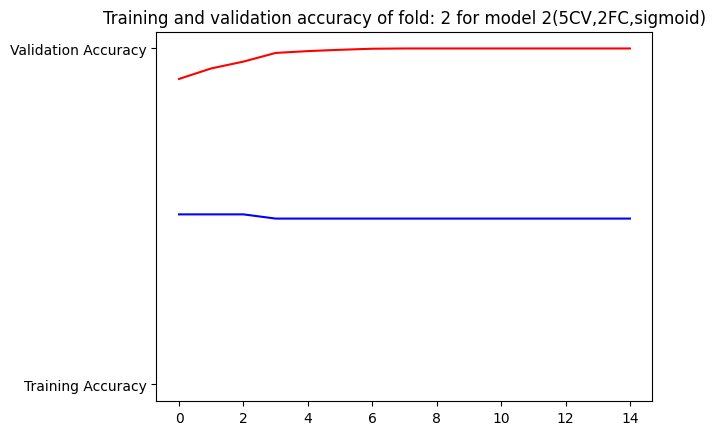

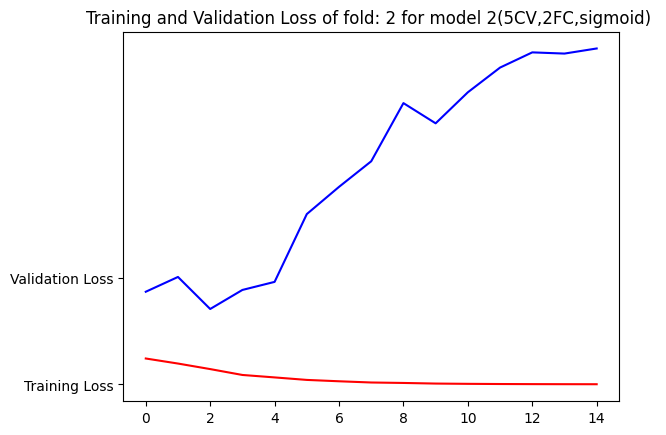

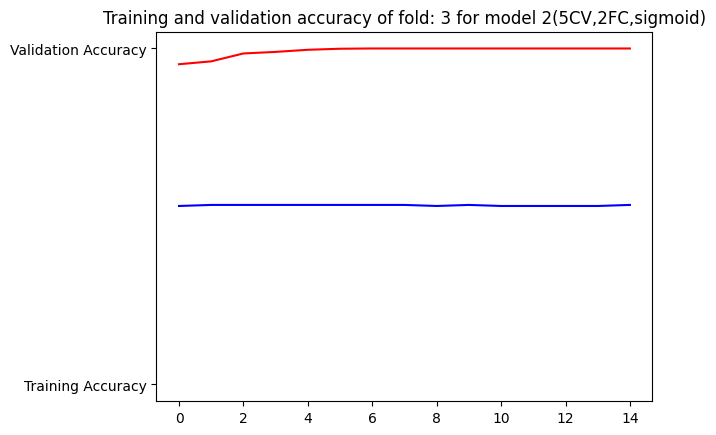

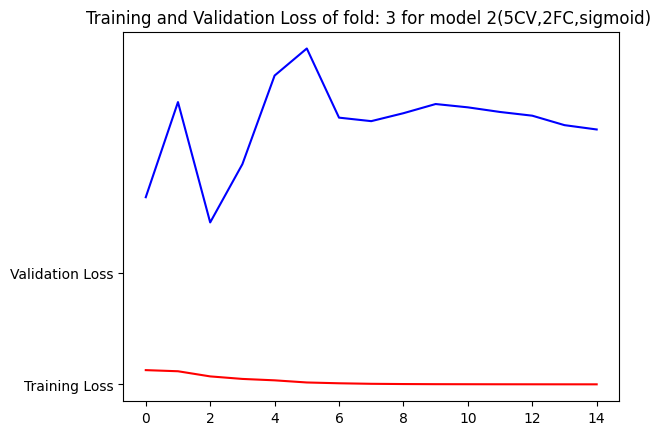

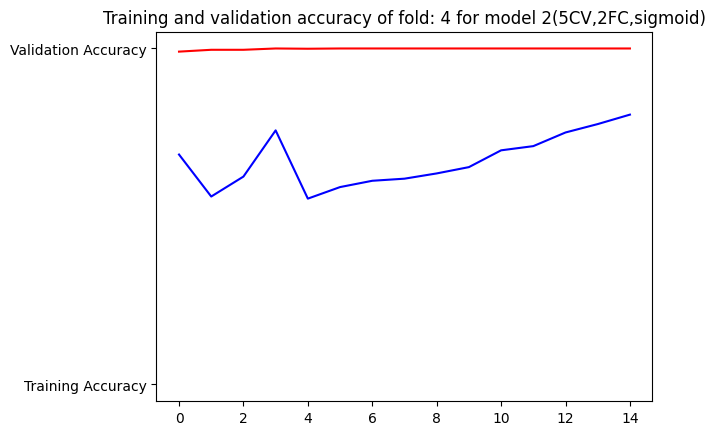

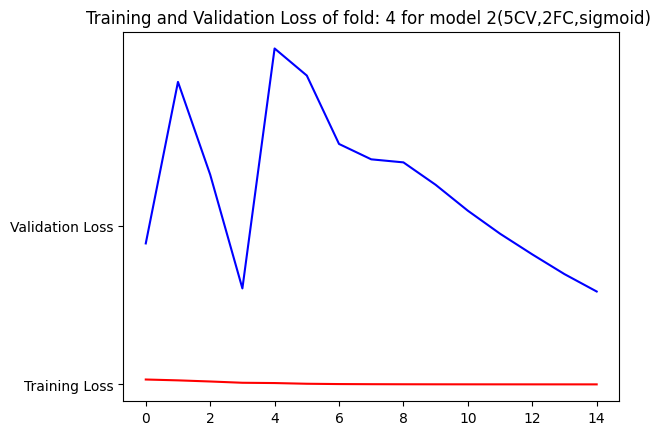

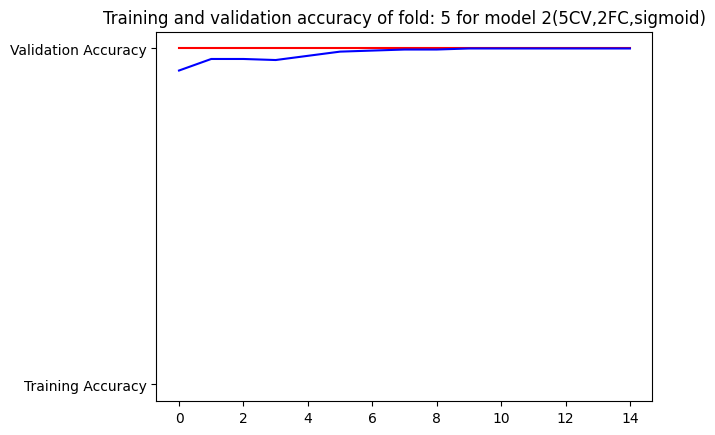

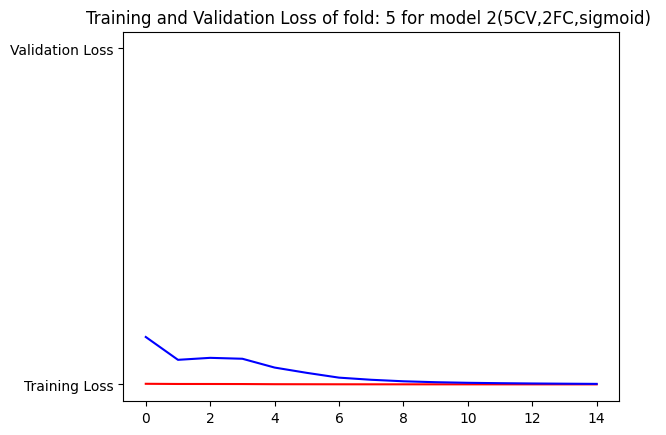

In [ ]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for model2 with Adam() and BinaryCrossentropy loss")
for i in range(5):
    loss=m2models[i][1].history["loss"]
    val_loss=m2models[i][1].history["val_loss"]
    acc=m2models[i][1].history['accuracy']
    val_acc=m2models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 2(5CV,2FC,sigmoid)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 2(5CV,2FC,sigmoid) ")
    plt.show()

Model 3 Adam(),BinaryCrossentropy

In [ ]:
m3models,m3test_acc,m3_cm,m3_pred=implementationwith5FOLD(model3)

Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15
10/10 [==============================] - 5s 392ms/step - loss: 2.4050 - accuracy: 0.5734 - auc: 0.6092 - val_loss: 0.8121 - val_accuracy: 0.4437 - val_auc: 0.5103
Epoch 2/15
10/10 [==============================] - 3s 322ms/step - loss: 0.9924 - accuracy: 0.7414 - auc: 0.8096 - val_loss: 0.7165 - val_accuracy: 0.4531 - val_auc: 0.5567
Epoch 3/15
10/10 [==============================] - 3s 324ms/step - loss: 0.5050 - accuracy: 0.8438 - auc: 0.9069 - val_loss: 1.0618 - val_accuracy: 0.4437 - val_auc: 0.5356
Epoch 4/15
10/10 [==============================] - 3s 320ms/step - loss: 0.3119 - accuracy: 0.8906 - auc: 0.9530 - val_loss: 0.6980 - val_accuracy: 0.5562 - val_auc: 0.6451
Epoch 5/15
10/10 [==============================] - 3s 323ms/step - loss: 0.2243 - accuracy: 0.9211 - a

In [ ]:
m3test_acc

[0.5, 0.5475, 0.6075, 0.7, 0.7475]

Plotting the loss and accuracy graphs for model3 with Adam() and BinaryCrossentropy loss


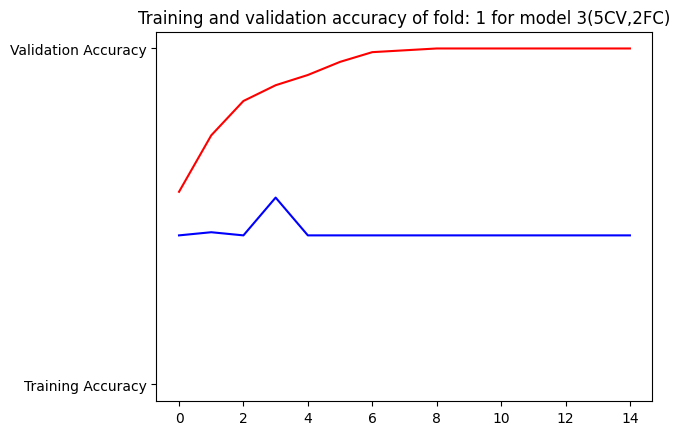

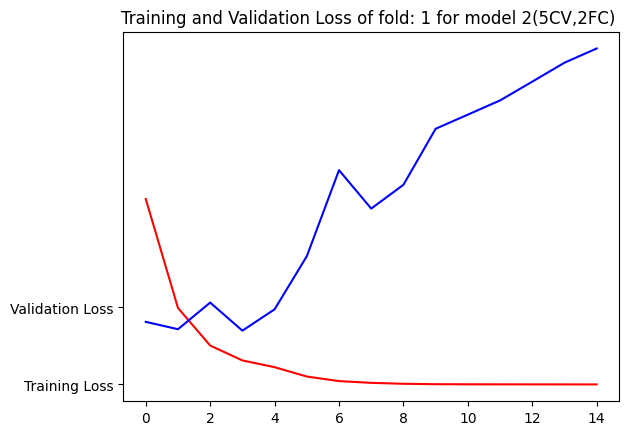

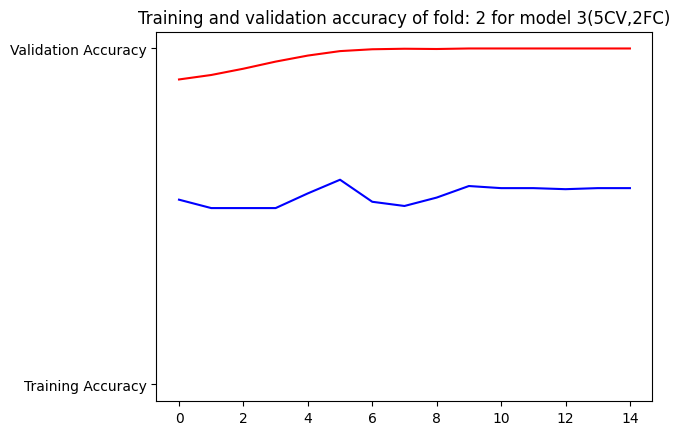

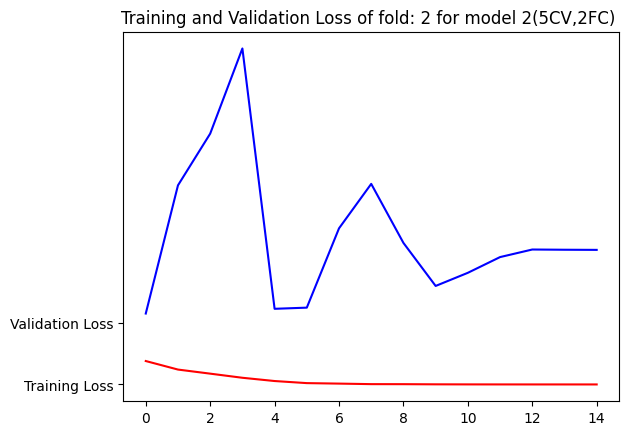

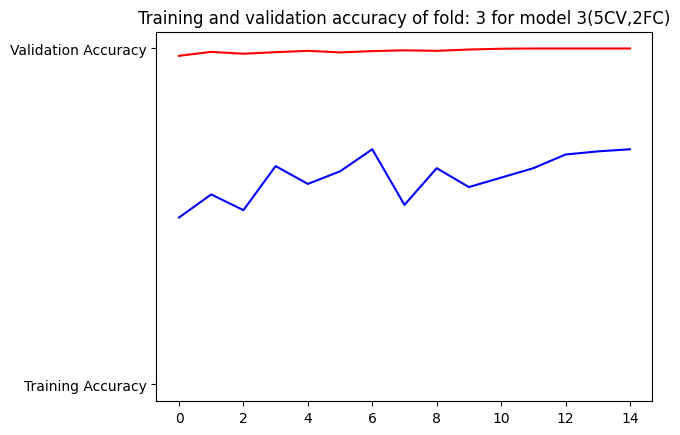

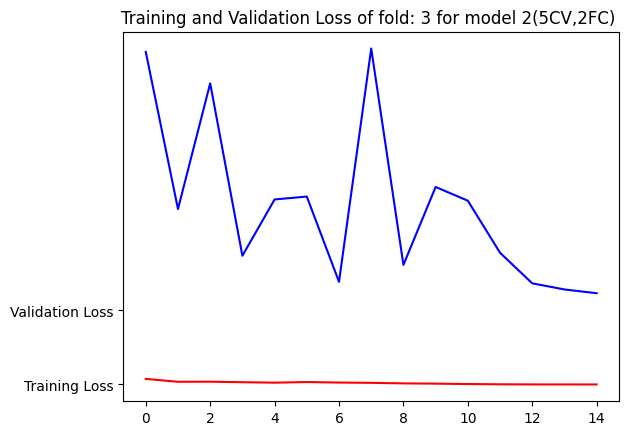

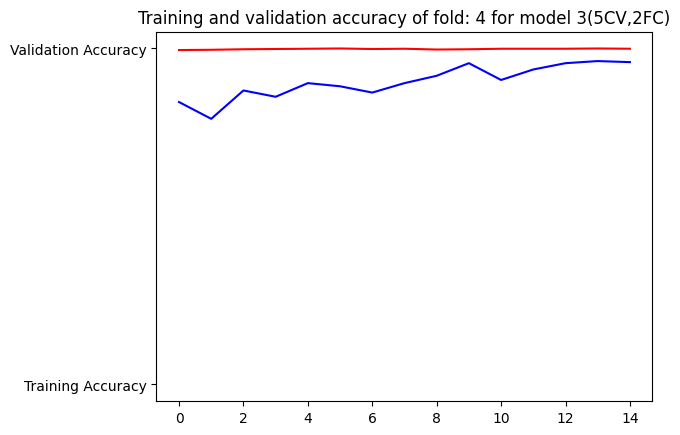

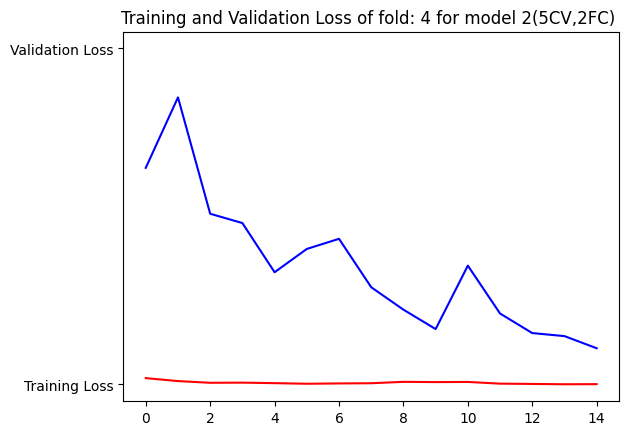

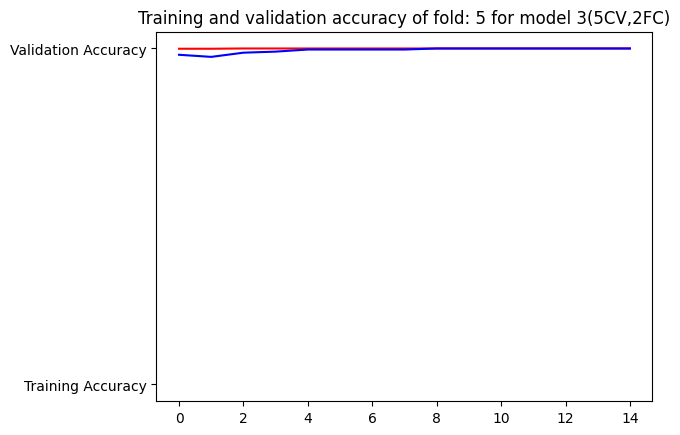

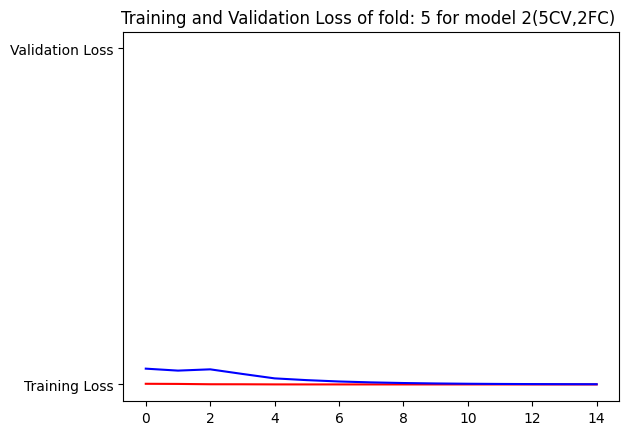

In [ ]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for model3 with Adam() and BinaryCrossentropy loss")
for i in range(5):
    loss=m3models[i][1].history["loss"]
    val_loss=m3models[i][1].history["val_loss"]
    acc=m3models[i][1].history['accuracy']
    val_acc=m3models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 3(5CV,2FC)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 2(5CV,2FC) ")
    plt.show()

ResNet 18 , Adam(),BinaryCrossEntropy

In [12]:
m4models,m4test_acc,m4_cm,m4_pred=implementationwith5FOLD(model4)

Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15


2023-01-09 19:44:23.439845: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-01-09 19:44:24.008157: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-09 19:44:24.059780: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 11s 239ms/step - loss: 0.8424 - accuracy: 0.5836 - val_loss: 91.4019 - val_accuracy: 0.4812
Epoch 2/15
20/20 [==============================] - 4s 219ms/step - loss: 0.6228 - accuracy: 0.6367 - val_loss: 46.8661 - val_accuracy: 0.4812
Epoch 3/15
20/20 [==============================] - 5s 223ms/step - loss: 0.5993 - accuracy: 0.6703 - val_loss: 25.6415 - val_accuracy: 0.4812
Epoch 4/15
20/20 [==============================] - 5s 231ms/step - loss: 0.5767 - accuracy: 0.6945 - val_loss: 4.9136 - val_accuracy: 0.4812
Epoch 5/15
20/20 [==============================] - 5s 235ms/step - loss: 0.5561 - accuracy: 0.7047 - val_loss: 2.0497 - val_accuracy: 0.4812
Epoch 6/15
20/20 [==============================] - 5s 249ms/step - loss: 0.5528 - accuracy: 0.7258 - val_loss: 1.2644 - val_accuracy: 0.4812
Epoch 7/15
20/20 [==============================] - 5s 258ms/step - loss: 0.5320 - accuracy: 0.7297 - val_loss: 1.0979 - val_accuracy: 0.4844
Epoch 8/15
20

In [13]:
m4test_acc

[0.6025, 0.67, 0.6475, 0.7, 0.6525]

Plotting the loss and accuracy graphs for ResNet18 with Adam() and BinaryCrossentropy loss


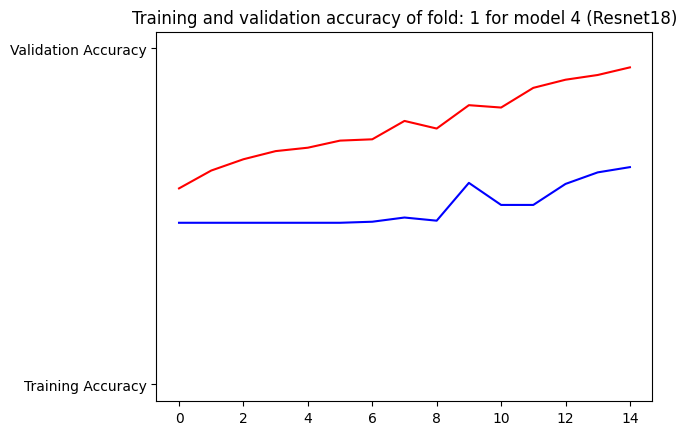

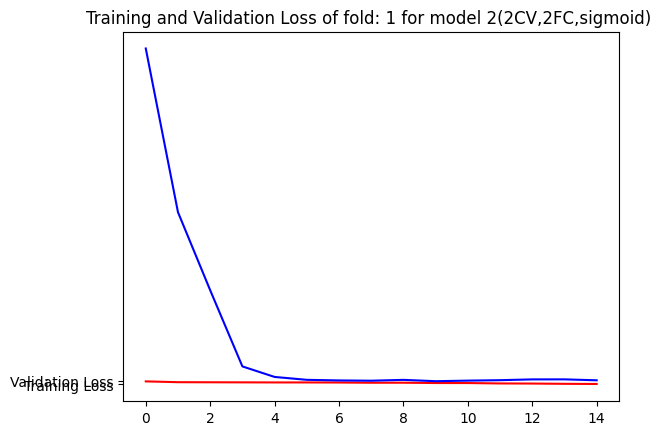

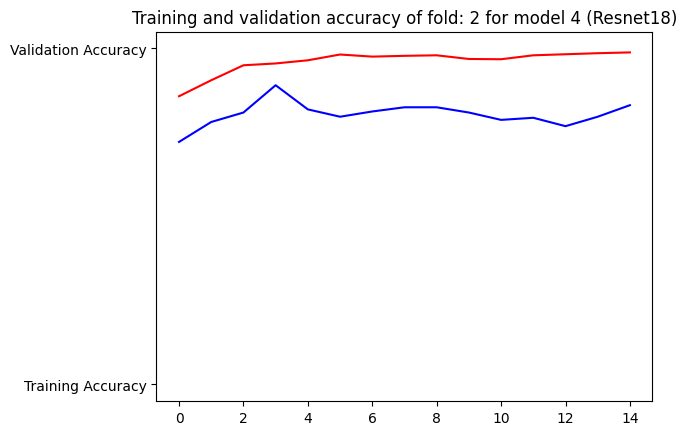

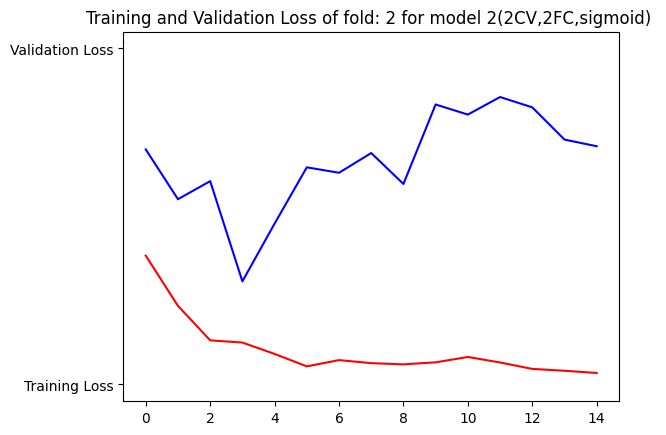

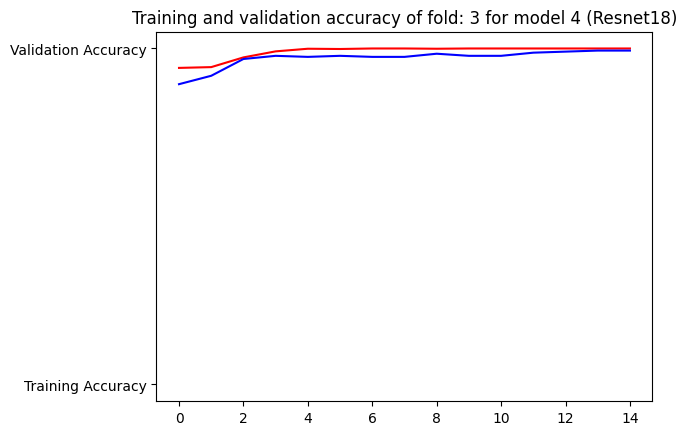

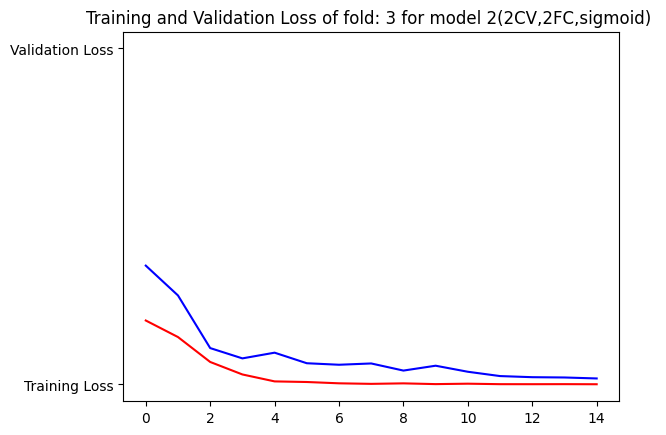

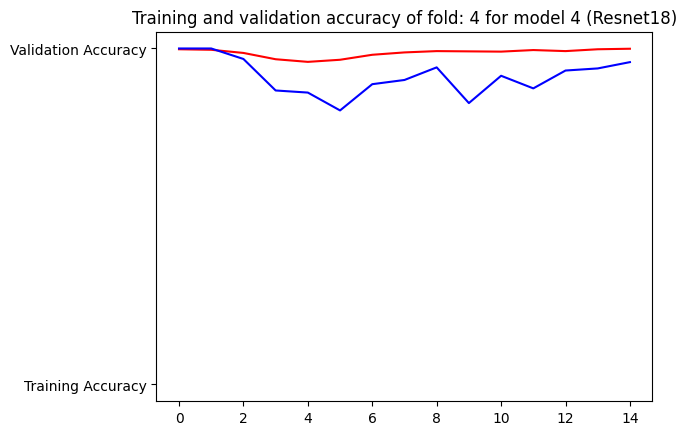

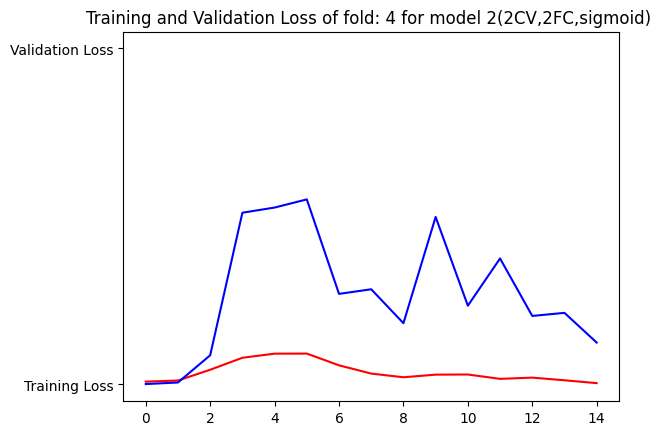

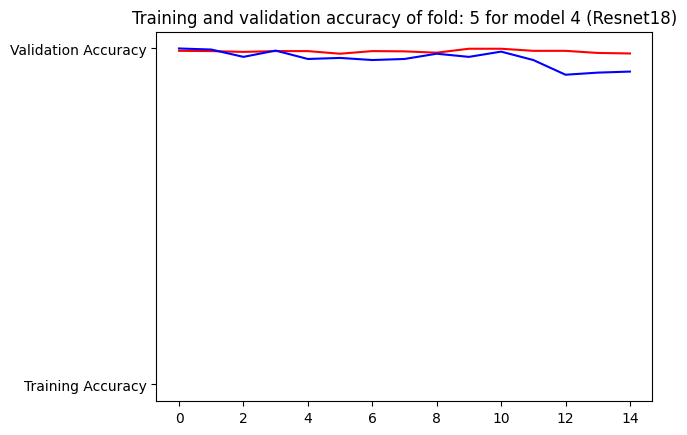

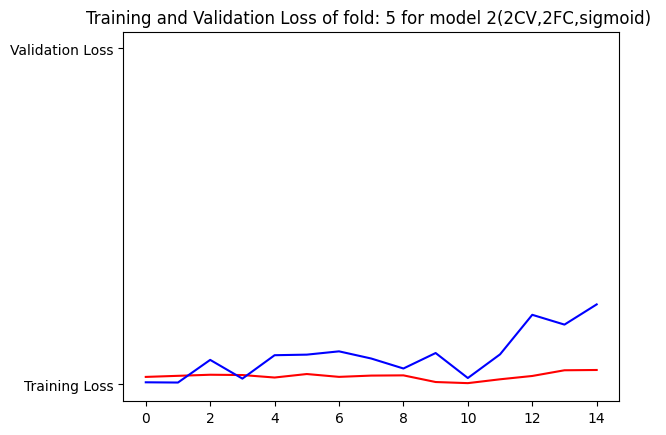

In [14]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for ResNet18 with Adam() and BinaryCrossentropy loss")
for i in range(5):
    loss=m4models[i][1].history["loss"]
    val_loss=m4models[i][1].history["val_loss"]
    acc=m4models[i][1].history['accuracy']
    val_acc=m4models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 4 (Resnet18)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 2(2CV,2FC,sigmoid) ")
    plt.show()

TRYING DIFFERENT OPTIMIZERS 

-Models with SGD Optimizer with learning_rate parameter=0.001 and BinaryCrossentropy loss And Their Results

In [12]:

def model1sgd():
    model=tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(200,200,3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid")
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=["accuracy",tf.keras.metrics.AUC(name="auc")])
    return model

model1sgd=model1sgd()

In [13]:
m1sgd_models,m1sgd_test_acc,m1sgd_cm,m1sgd_pred=implementationwith5FOLD(model1sgd)

Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15
20/20 [==============================] - 6s 211ms/step - loss: 0.8213 - accuracy: 0.5484 - auc: 0.5837 - val_loss: 0.6851 - val_accuracy: 0.5562 - val_auc: 0.5891
Epoch 2/15
20/20 [==============================] - 3s 170ms/step - loss: 0.4198 - accuracy: 0.8086 - auc: 0.8967 - val_loss: 0.6874 - val_accuracy: 0.5688 - val_auc: 0.5836
Epoch 3/15
20/20 [==============================] - 3s 173ms/step - loss: 0.2823 - accuracy: 0.9242 - auc: 0.9754 - val_loss: 0.6876 - val_accuracy: 0.5469 - val_auc: 0.5660
Epoch 4/15
20/20 [==============================] - 3s 156ms/step - loss: 0.2134 - accuracy: 0.9578 - auc: 0.9946 - val_loss: 0.6889 - val_accuracy: 0.5562 - val_auc: 0.5550
Epoch 5/15
20/20 [==============================] - 3s 157ms/step - loss: 0.1672 - accuracy: 0.9852 - a

In [17]:
m1sgd_test_acc

[0.5025, 0.63, 0.66, 0.66, 0.67]

Plotting the loss and accuracy graphs for model1 with SGD optimizer and BinaryCrossentropy loss


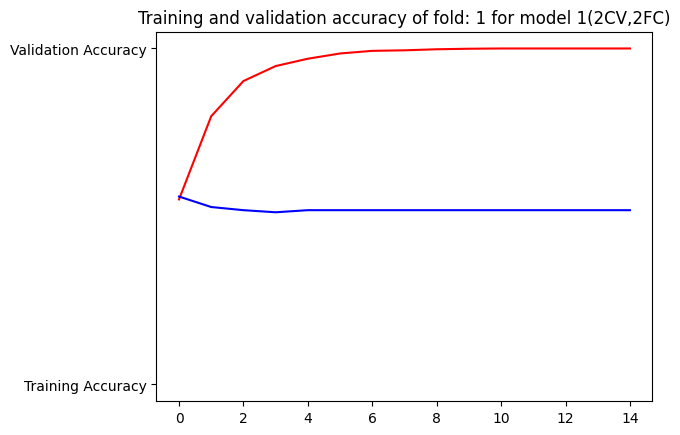

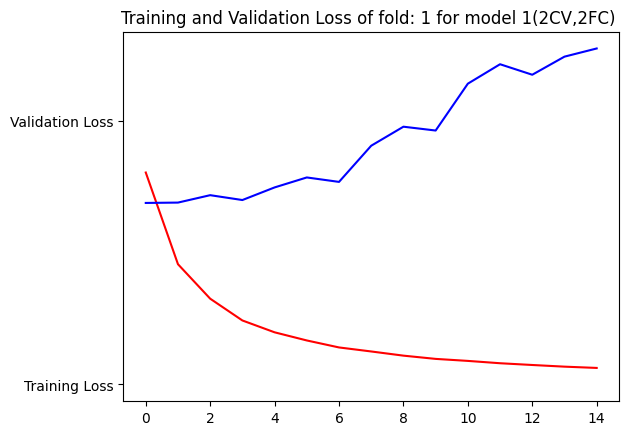

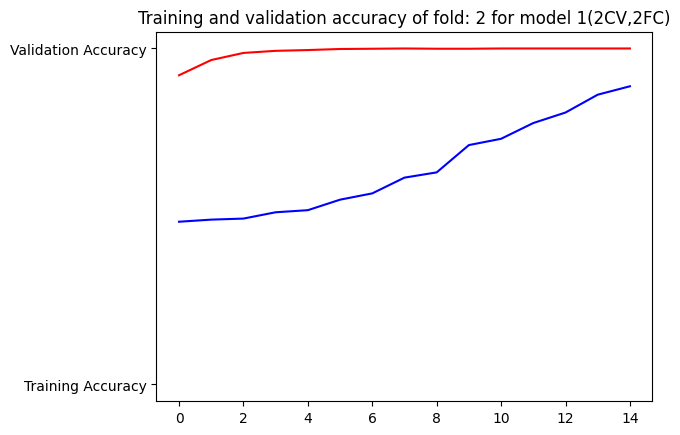

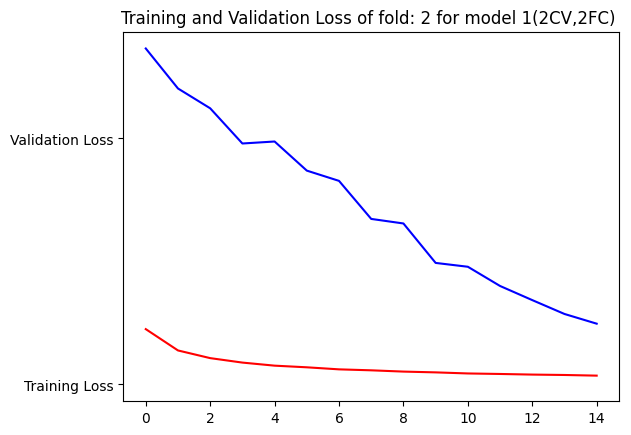

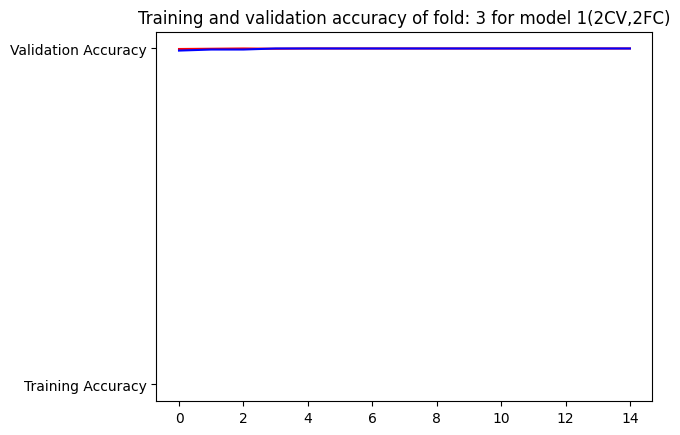

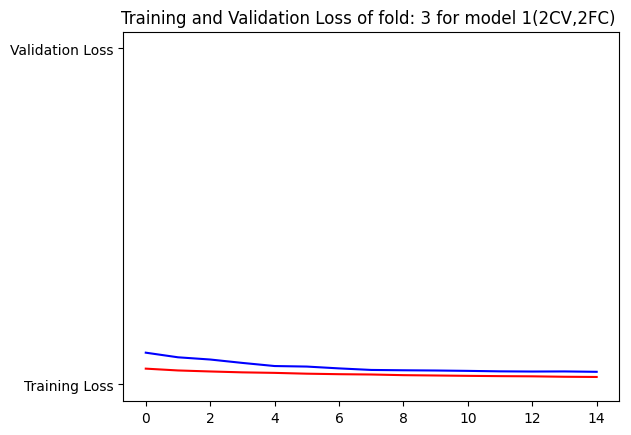

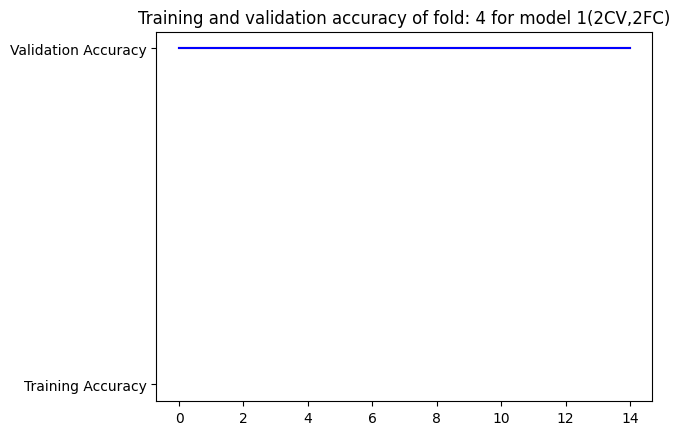

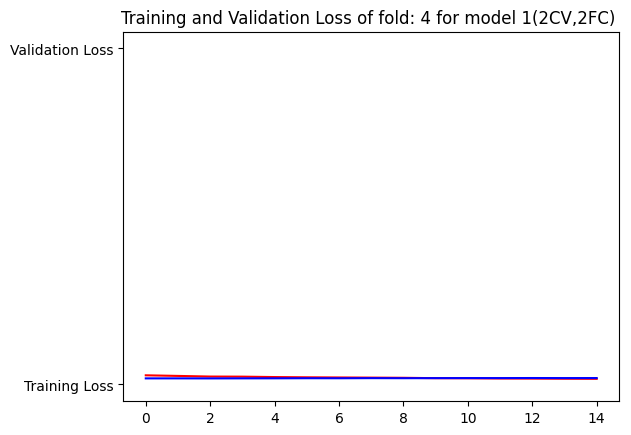

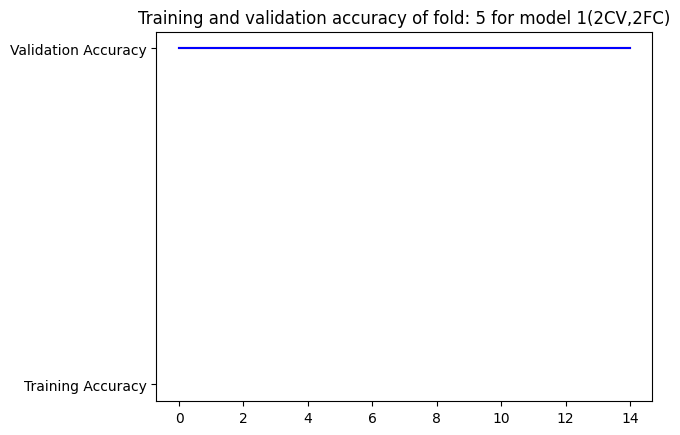

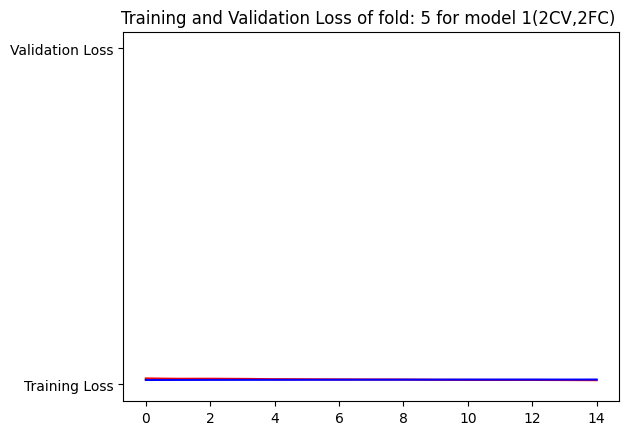

In [20]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for model1 with SGD optimizer and BinaryCrossentropy loss")
for i in range(5):
    loss=m1sgd_models[i][1].history["loss"]
    val_loss=m1sgd_models[i][1].history["val_loss"]
    acc=m1sgd_models[i][1].history['accuracy']
    val_acc=m1sgd_models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 1(2CV,2FC)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 1(2CV,2FC) ")
    plt.show()

In [21]:
def model2sgd():
  model=tf.keras.Sequential([
      tf.keras.layers.Conv2D(32,(3,3),activation="sigmoid",input_shape=(200,200,3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128,(3,3),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256,(2,2),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(512,(2,2),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256,activation="sigmoid"),
      tf.keras.layers.Dense(1,activation="sigmoid"),
      
  ])
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                loss="binary_crossentropy",
                metrics=["accuracy",tf.keras.metrics.AUC(name="auc")])
  return model

model2sgd=model2sgd()

In [22]:
m2sgd_models,m2sgd_test_acc,m2sgd_cm,m2sgd_pred=implementationwith5FOLD(model2sgd)

Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15
20/20 [==============================] - 5s 157ms/step - loss: 0.6907 - accuracy: 0.5484 - auc: 0.5700 - val_loss: 0.6968 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/15
20/20 [==============================] - 3s 143ms/step - loss: 0.6566 - accuracy: 0.6078 - auc: 0.6526 - val_loss: 0.6981 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/15
20/20 [==============================] - 3s 145ms/step - loss: 0.6373 - accuracy: 0.6383 - auc: 0.6909 - val_loss: 0.6987 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 4/15
20/20 [==============================] - 3s 138ms/step - loss: 0.6246 - accuracy: 0.6469 - auc: 0.7132 - val_loss: 0.6986 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 5/15
20/20 [==============================] - 3s 137ms/step - loss: 0.6126 - accuracy: 0.6719 - a

In [23]:
m2sgd_test_acc

[0.5, 0.59, 0.715, 0.705, 0.7175]

Plotting the loss and accuracy graphs for model2 with SGD optimizer and BinaryCrossentropy loss


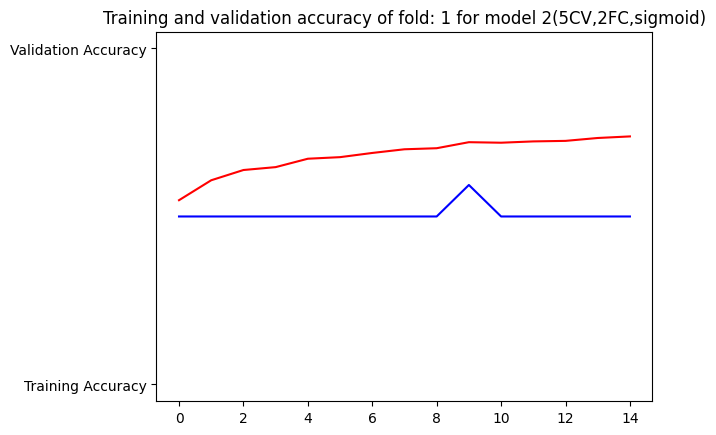

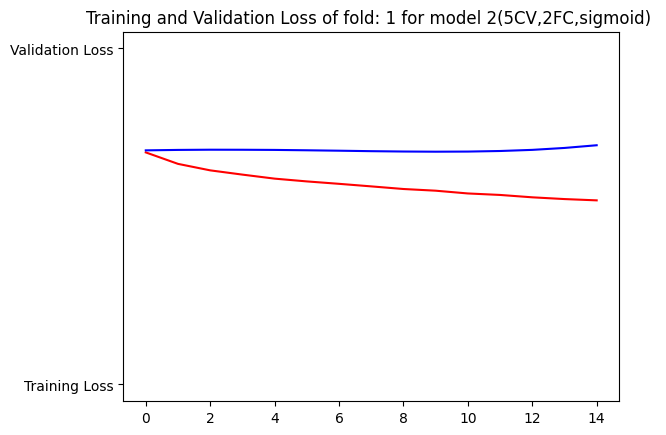

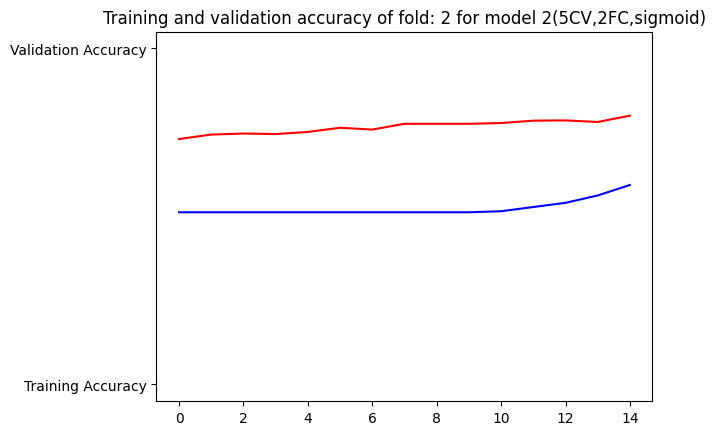

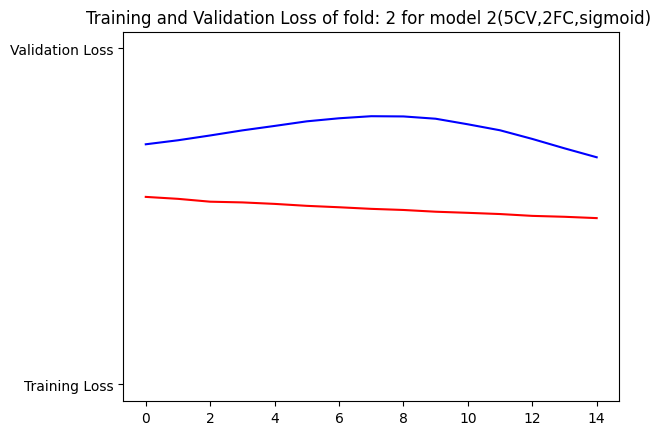

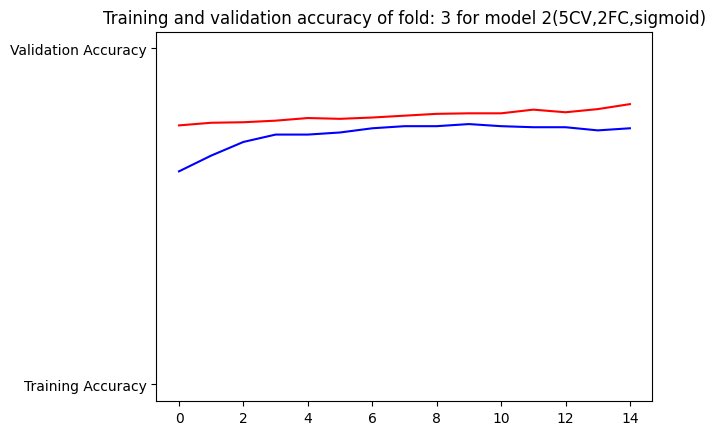

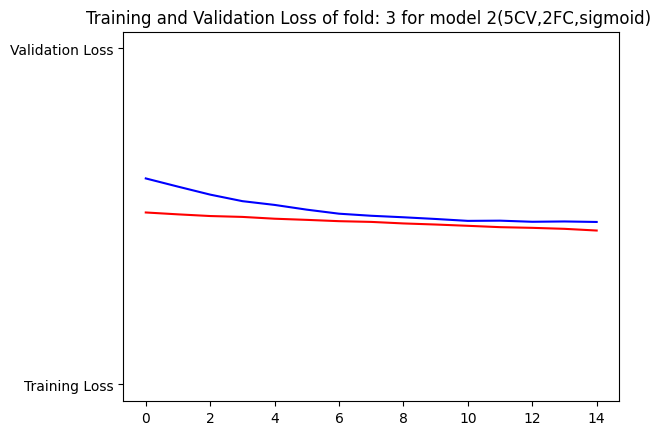

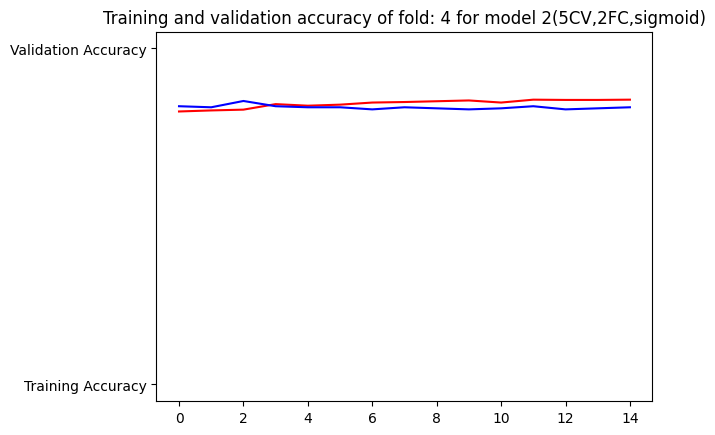

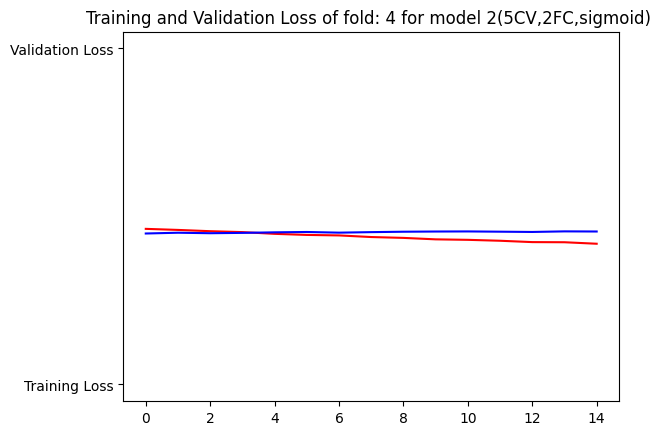

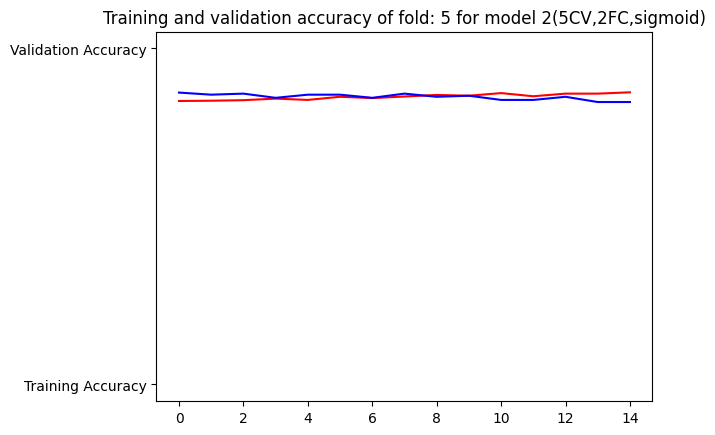

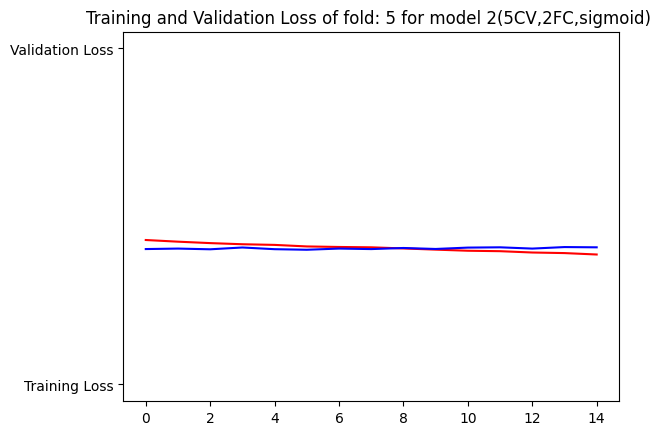

In [24]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for model2 with SGD optimizer and BinaryCrossentropy loss")
for i in range(5):
    loss=m2sgd_models[i][1].history["loss"]
    val_loss=m2sgd_models[i][1].history["val_loss"]
    acc=m2sgd_models[i][1].history['accuracy']
    val_acc=m2sgd_models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 2(5CV,2FC,sigmoid)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 2(5CV,2FC,sigmoid) ")
    plt.show()

In [25]:
def model3sgd():
    model=tf.keras.Sequential([
      tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(200,200,3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256,(2,2),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(512,(2,2),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256,activation="relu"),
      tf.keras.layers.Dense(1,activation="sigmoid"),
      
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                loss="binary_crossentropy",
                metrics=["accuracy",tf.keras.metrics.AUC(name="auc")])
    return model
model3sgd=model3sgd()

In [26]:
m3sgd_models,m3sgd_test_acc,m3sgd_cm,m3sgd_pred=implementationwith5FOLD(model3sgd)

Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15
20/20 [==============================] - 5s 178ms/step - loss: 0.7565 - accuracy: 0.5453 - auc: 0.5796 - val_loss: 0.6937 - val_accuracy: 0.4781 - val_auc: 0.5262
Epoch 2/15
20/20 [==============================] - 3s 155ms/step - loss: 0.6037 - accuracy: 0.6883 - auc: 0.7408 - val_loss: 0.7023 - val_accuracy: 0.4750 - val_auc: 0.5969
Epoch 3/15
20/20 [==============================] - 3s 154ms/step - loss: 0.5236 - accuracy: 0.7383 - auc: 0.8225 - val_loss: 0.7238 - val_accuracy: 0.4750 - val_auc: 0.6390
Epoch 4/15
20/20 [==============================] - 3s 158ms/step - loss: 0.4691 - accuracy: 0.7875 - auc: 0.8724 - val_loss: 0.7316 - val_accuracy: 0.4750 - val_auc: 0.6468
Epoch 5/15
20/20 [==============================] - 3s 151ms/step - loss: 0.4217 - accuracy: 0.8383 - a

In [27]:
m3sgd_test_acc

[0.5, 0.66, 0.73, 0.745, 0.735]

Plotting the loss and accuracy graphs for model3 with SGD optimizer and BinaryCrossentropy loss


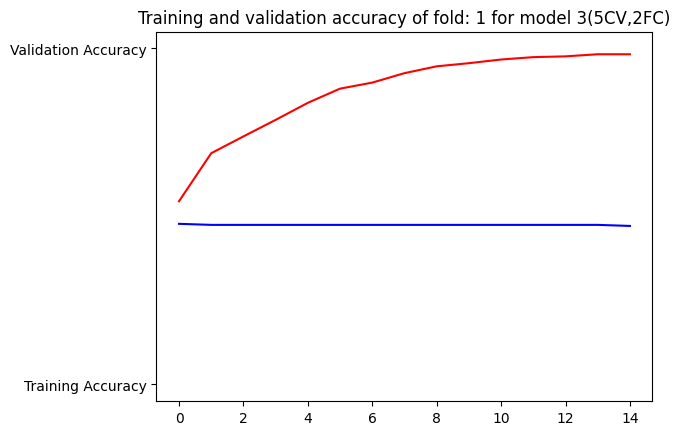

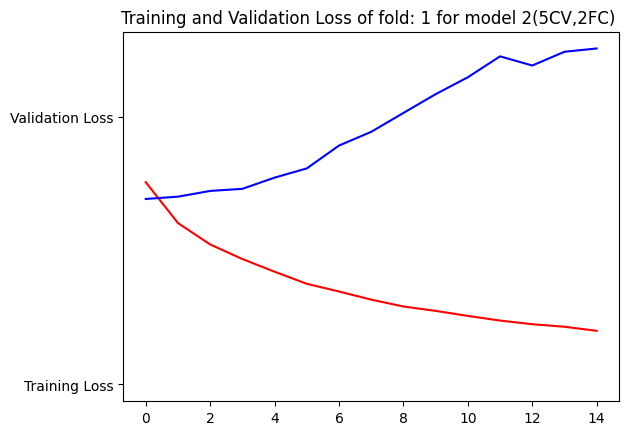

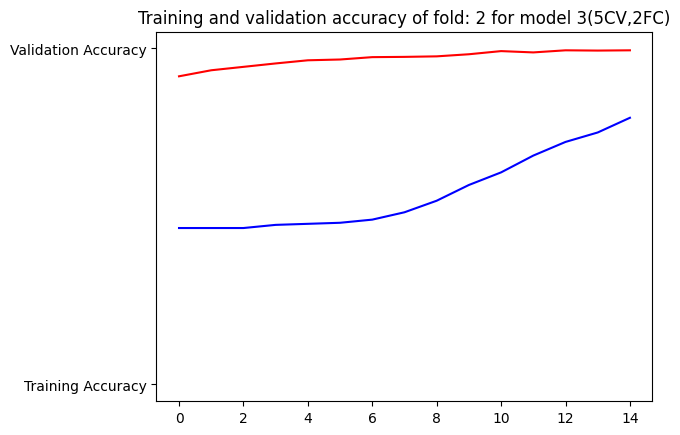

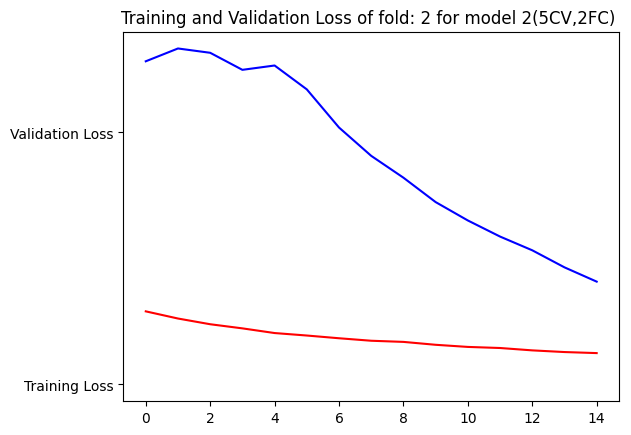

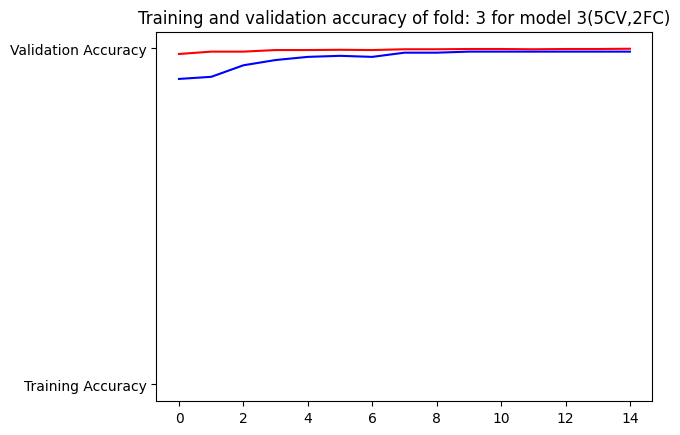

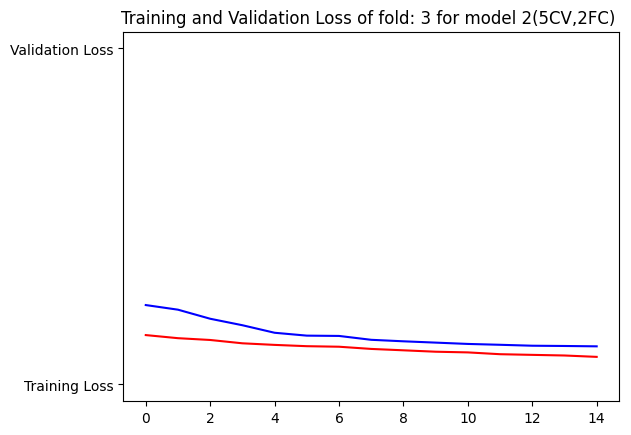

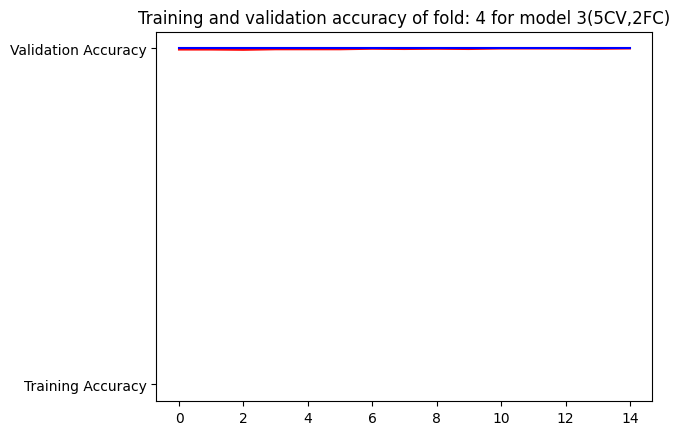

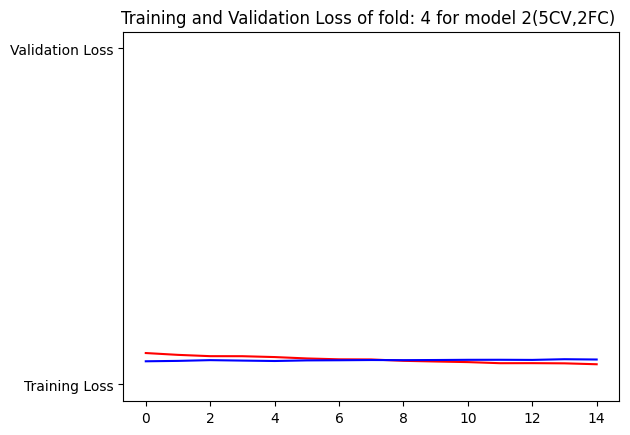

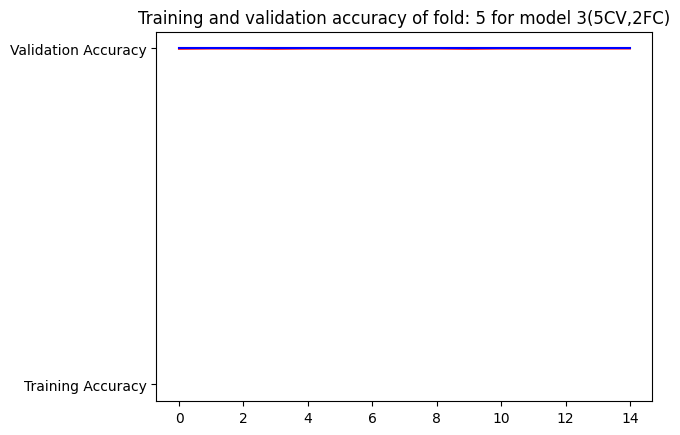

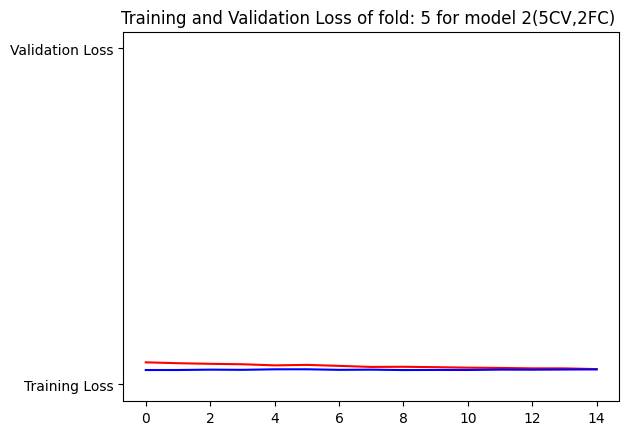

In [28]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for model3 with SGD optimizer and BinaryCrossentropy loss")
for i in range(5):
    loss=m3sgd_models[i][1].history["loss"]
    val_loss=m3sgd_models[i][1].history["val_loss"]
    acc=m3sgd_models[i][1].history['accuracy']
    val_acc=m3sgd_models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 3(5CV,2FC)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 2(5CV,2FC) ")
    plt.show()

In [8]:

def model4sgd():
    # for tensorflow.keras
    # from classification_models.tfkeras import Classifiers

    ResNet18, preprocess_input = Classifiers.get('resnet18')
    n_classes = 1

    base_model = ResNet18(input_shape=(200,200,3), include_top=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(n_classes, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                 loss="binary_crossentropy",
                 metrics=["accuracy"])
    model.summary()
    return model
model4sgd=model4sgd()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 200, 200, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 100, 100, 64  9408        ['zero_padding2d[0][0]']   

In [9]:
m4sgd_models,m4sgd_test_acc,m4sgd_cm,m4sgd_pred=implementationwith5FOLD(model4sgd)

Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15
20/20 [==============================] - 12s 291ms/step - loss: 0.7202 - accuracy: 0.4977 - val_loss: 1.3095 - val_accuracy: 0.5094
Epoch 2/15
20/20 [==============================] - 5s 263ms/step - loss: 0.7006 - accuracy: 0.5008 - val_loss: 0.7008 - val_accuracy: 0.5094
Epoch 3/15
20/20 [==============================] - 5s 263ms/step - loss: 0.6881 - accuracy: 0.5242 - val_loss: 0.6920 - val_accuracy: 0.5188
Epoch 4/15
20/20 [==============================] - 5s 264ms/step - loss: 0.6816 - accuracy: 0.5617 - val_loss: 0.6948 - val_accuracy: 0.4625
Epoch 5/15
20/20 [==============================] - 5s 265ms/step - loss: 0.6772 - accuracy: 0.6000 - val_loss: 0.6945 - val_accuracy: 0.4812
Epoch 6/15
20/20 [==============================] - 5s 263ms/step - loss: 0.6748 - accur

In [10]:
m4sgd_test_acc

[0.535, 0.56, 0.5775, 0.5875, 0.6025]

Plotting the loss and accuracy graphs for ResNet18 with SGD and BinaryCrossentropy loss


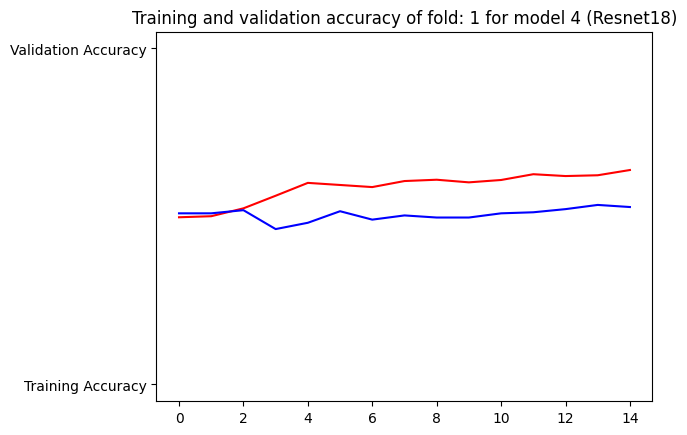

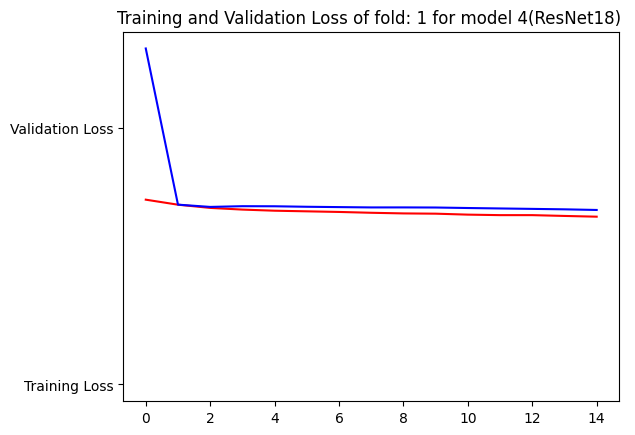

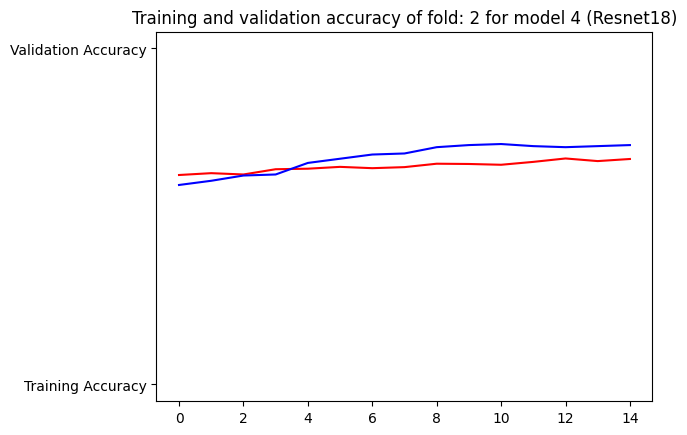

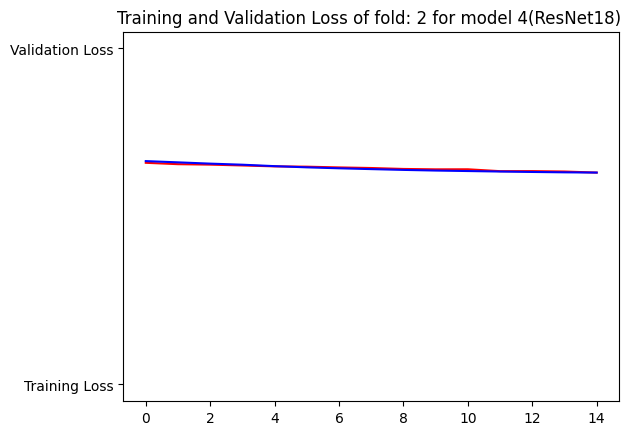

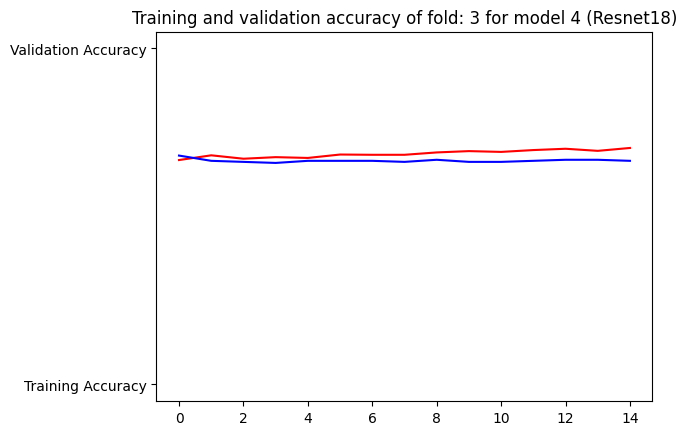

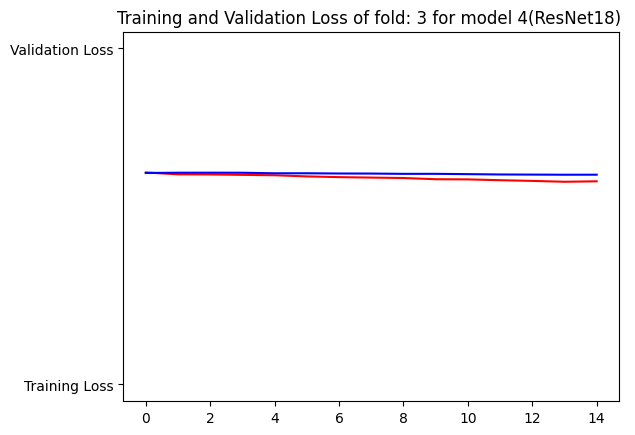

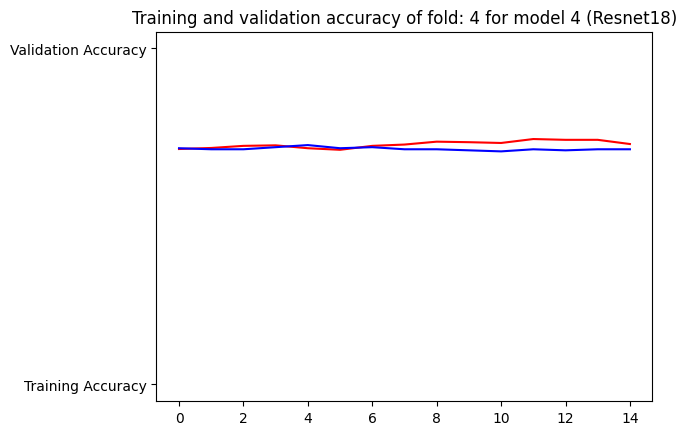

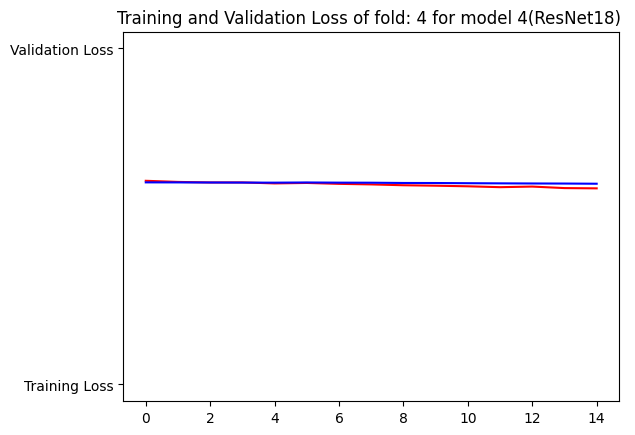

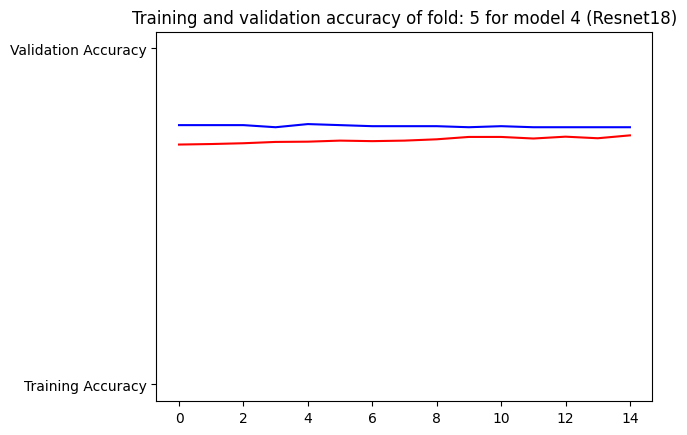

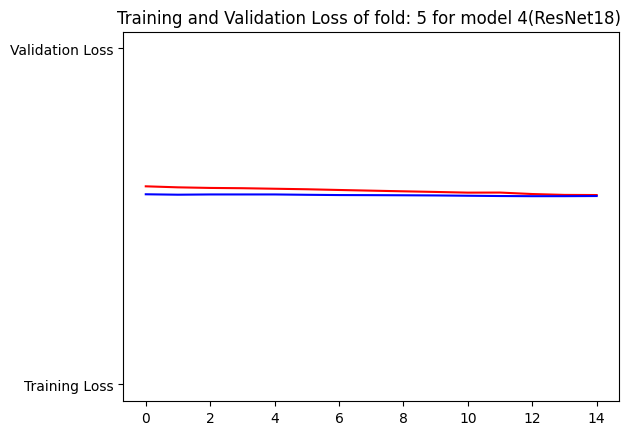

In [11]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for ResNet18 with SGD and BinaryCrossentropy loss")
for i in range(5):
    loss=m4sgd_models[i][1].history["loss"]
    val_loss=m4sgd_models[i][1].history["val_loss"]
    acc=m4sgd_models[i][1].history['accuracy']
    val_acc=m4sgd_models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 4 (Resnet18)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 4(ResNet18) ")
    plt.show()

MODELS WITH OPTIMIZER RMSprop (learning_rate=0.001)
loss= Binary Crossentropy

In [33]:

def model1rms():
    model=tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(200,200,3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid")
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=["accuracy",tf.keras.metrics.AUC(name="auc")])
    return model

model1rms=model1rms()

In [34]:
m1rms_models,m1rms_test_acc,m1rms_cm,m1rms_pred=implementationwith5FOLD(model1rms)

Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15
20/20 [==============================] - 3s 126ms/step - loss: 19.8880 - accuracy: 0.5797 - auc: 0.5972 - val_loss: 0.6882 - val_accuracy: 0.4656 - val_auc: 0.5235
Epoch 2/15
20/20 [==============================] - 2s 115ms/step - loss: 6.7501 - accuracy: 0.6734 - auc: 0.7238 - val_loss: 0.6884 - val_accuracy: 0.5500 - val_auc: 0.5695
Epoch 3/15
20/20 [==============================] - 2s 110ms/step - loss: 2.3690 - accuracy: 0.7633 - auc: 0.8366 - val_loss: 0.6951 - val_accuracy: 0.4625 - val_auc: 0.4755
Epoch 4/15
20/20 [==============================] - 2s 112ms/step - loss: 1.8587 - accuracy: 0.7883 - auc: 0.8556 - val_loss: 0.6978 - val_accuracy: 0.5312 - val_auc: 0.4760
Epoch 5/15
20/20 [==============================] - 2s 114ms/step - loss: 1.3544 - accuracy: 0.8367 - 

In [35]:
m1rms_test_acc

[0.5, 0.645, 0.655, 0.6675, 0.595]

Plotting the loss and accuracy graphs for model1 with RMSprop optimizer and BinaryCrossentropy loss


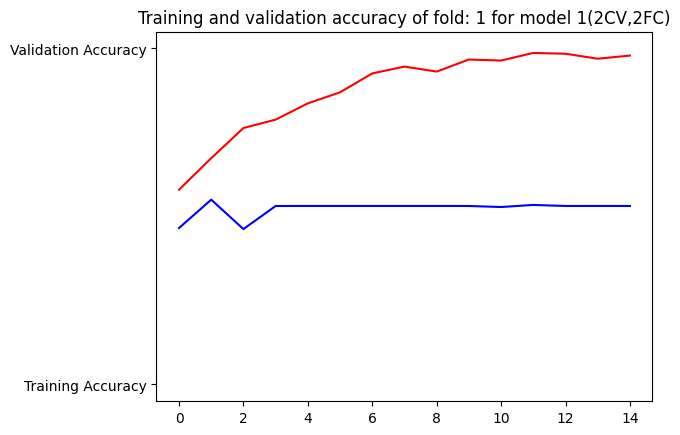

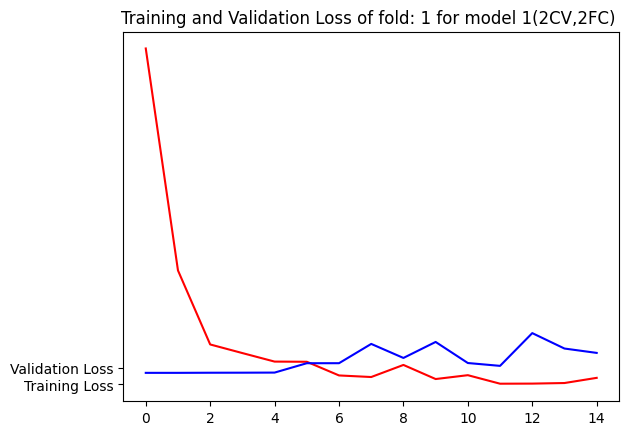

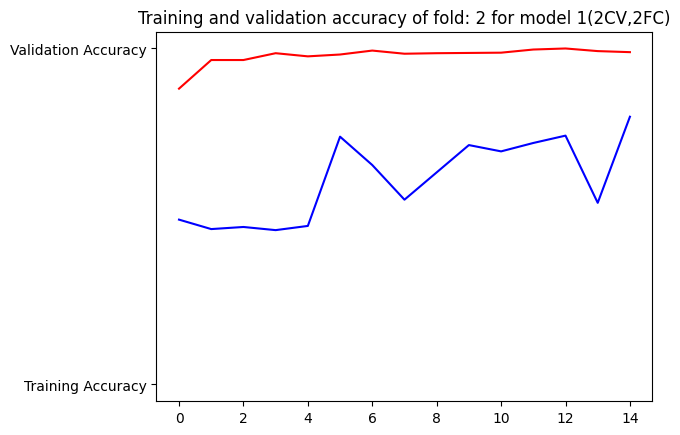

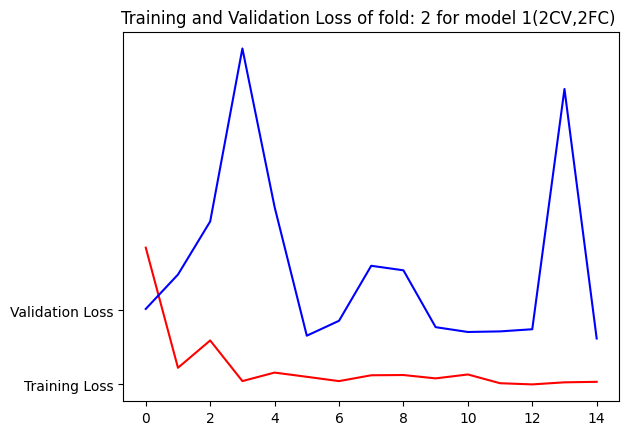

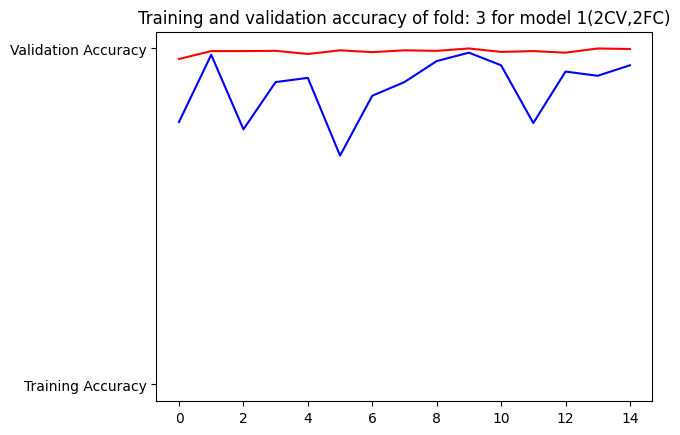

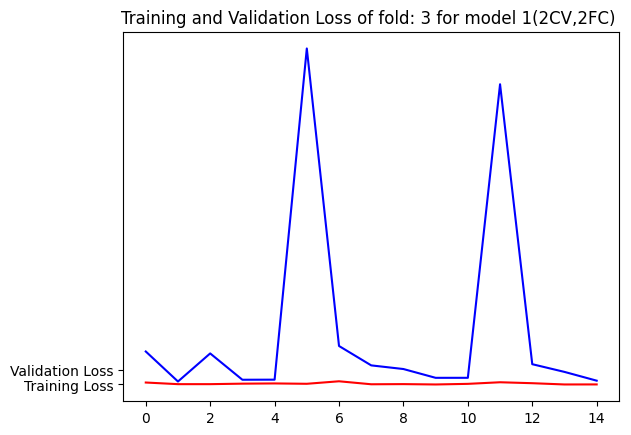

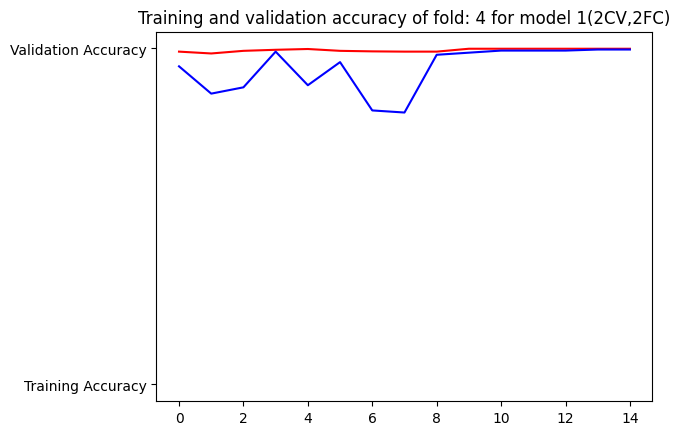

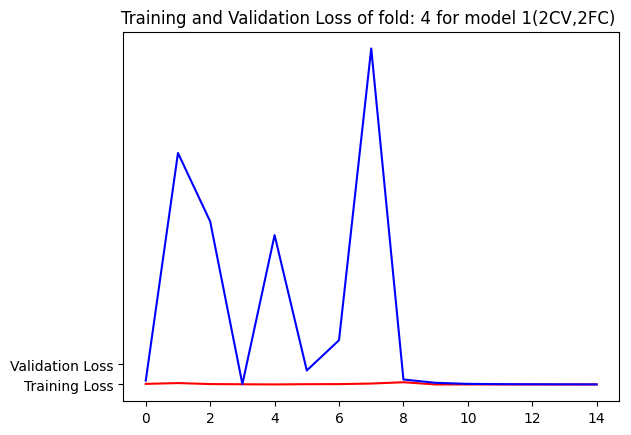

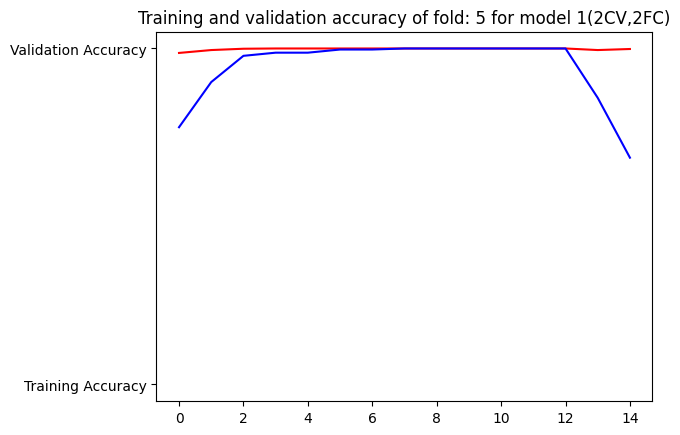

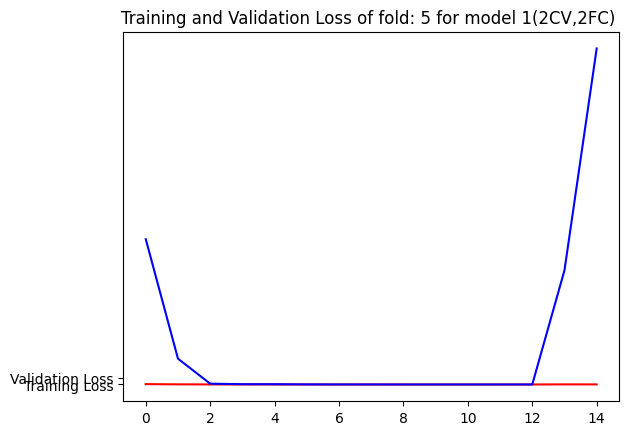

In [36]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for model1 with RMSprop optimizer and BinaryCrossentropy loss")
for i in range(5):
    loss=m1rms_models[i][1].history["loss"]
    val_loss=m1rms_models[i][1].history["val_loss"]
    acc=m1rms_models[i][1].history['accuracy']
    val_acc=m1rms_models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 1(2CV,2FC)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 1(2CV,2FC) ")
    plt.show()

In [37]:
def model2rms():
  model=tf.keras.Sequential([
      tf.keras.layers.Conv2D(32,(3,3),activation="sigmoid",input_shape=(200,200,3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128,(3,3),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256,(2,2),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(512,(2,2),activation="sigmoid"),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256,activation="sigmoid"),
      tf.keras.layers.Dense(1,activation="sigmoid"),
      
  ])
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss="binary_crossentropy",
                metrics=["accuracy",tf.keras.metrics.AUC(name="auc")])
  return model

model2rms=model2rms()

In [38]:
m2rms_models,m2rms_test_acc,m2rms_cm,m2rms_pred=implementationwith5FOLD(model2rms)



Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15
20/20 [==============================] - 4s 164ms/step - loss: 1.0633 - accuracy: 0.5781 - auc: 0.5951 - val_loss: 1.2916 - val_accuracy: 0.4969 - val_auc: 0.5000
Epoch 2/15
20/20 [==============================] - 3s 151ms/step - loss: 0.6366 - accuracy: 0.6367 - auc: 0.6989 - val_loss: 1.0558 - val_accuracy: 0.4969 - val_auc: 0.4969
Epoch 3/15
20/20 [==============================] - 3s 154ms/step - loss: 0.6388 - accuracy: 0.6328 - auc: 0.6964 - val_loss: 0.9834 - val_accuracy: 0.4969 - val_auc: 0.4637
Epoch 4/15
20/20 [==============================] - 3s 147ms/step - loss: 0.6330 - accuracy: 0.6477 - auc: 0.7031 - val_loss: 1.0193 - val_accuracy: 0.4969 - val_auc: 0.5506
Epoch 5/15
20/20 [==============================] - 3s 148ms/step - loss: 0.5838 - accuracy: 0.6797 - a

In [39]:
m1rms_test_acc

[0.5, 0.645, 0.655, 0.6675, 0.595]

Plotting the loss and accuracy graphs for model2 with RMSprop optimizer and BinaryCrossentropy loss


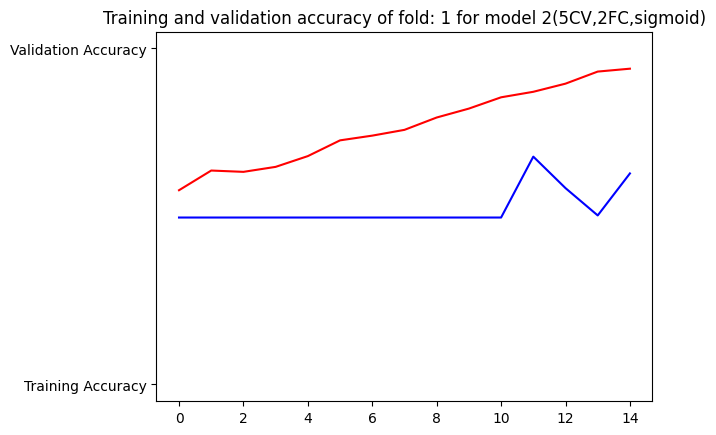

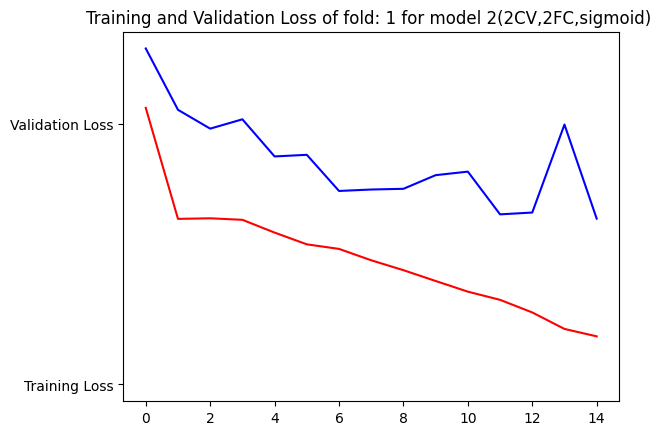

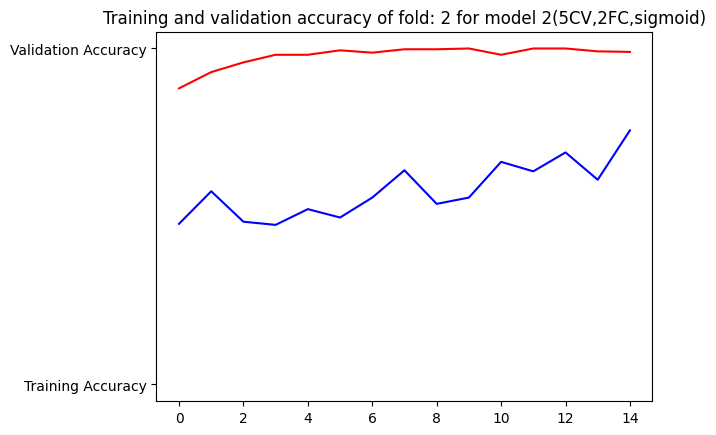

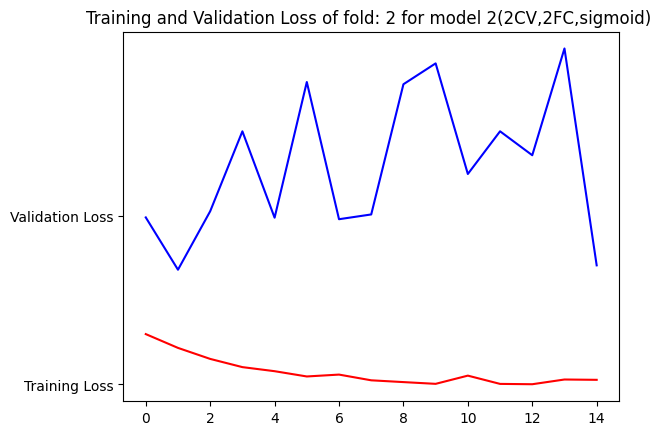

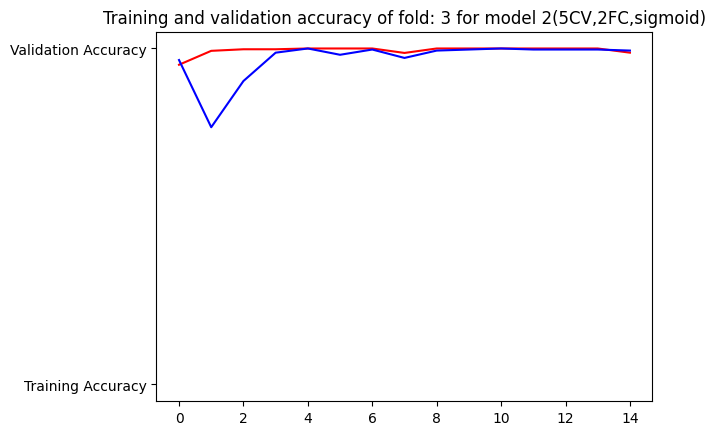

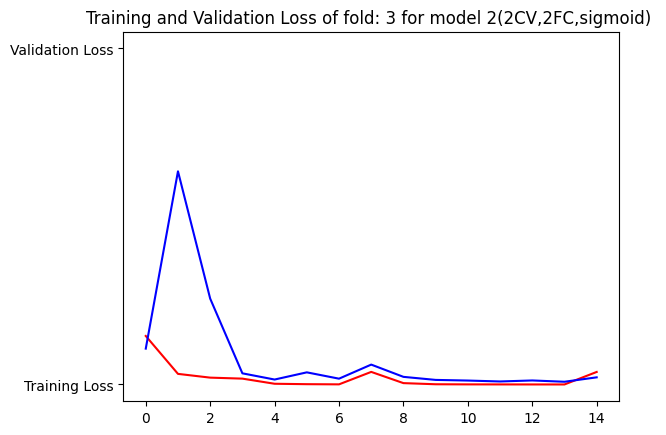

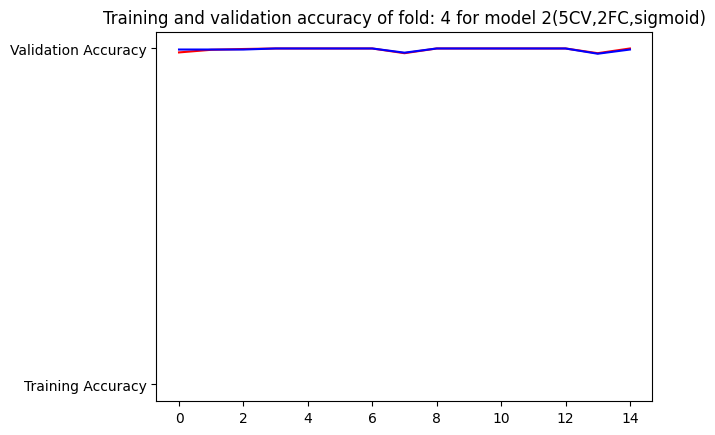

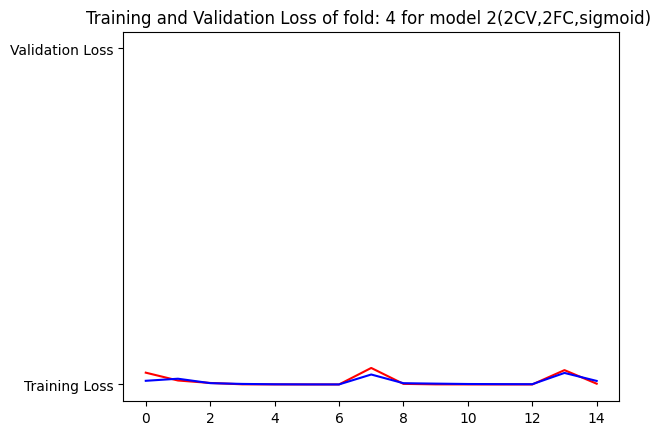

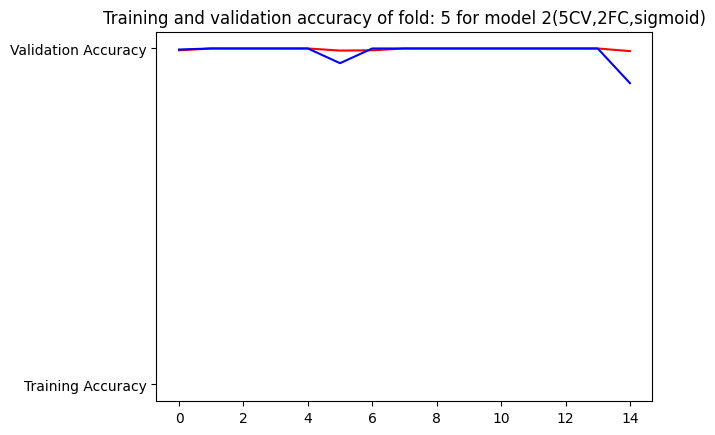

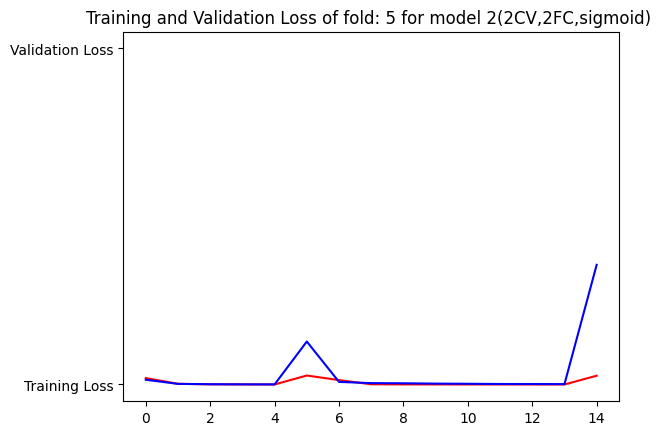

In [40]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for model2 with RMSprop optimizer and BinaryCrossentropy loss")
for i in range(5):
    loss=m2rms_models[i][1].history["loss"]
    val_loss=m2rms_models[i][1].history["val_loss"]
    acc=m2rms_models[i][1].history['accuracy']
    val_acc=m2rms_models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 2(5CV,2FC,sigmoid)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 2(2CV,2FC,sigmoid) ")
    plt.show()

In [41]:
def model3rms():
    model=tf.keras.Sequential([
      tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(200,200,3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256,(2,2),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(512,(2,2),activation="relu"),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256,activation="relu"),
      tf.keras.layers.Dense(1,activation="sigmoid"),
      
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss="binary_crossentropy",
                metrics=["accuracy",tf.keras.metrics.AUC(name="auc")])
    return model
model3rms=model3rms()

In [42]:
m3rms_models,m3rms_test_acc,m3rms_cm,m3rms_pred=implementationwith5FOLD(model3rms)

Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15
20/20 [==============================] - 5s 174ms/step - loss: 7.6432 - accuracy: 0.5477 - auc: 0.5594 - val_loss: 0.7050 - val_accuracy: 0.4781 - val_auc: 0.5600
Epoch 2/15
20/20 [==============================] - 3s 149ms/step - loss: 2.6703 - accuracy: 0.6375 - auc: 0.6817 - val_loss: 3.0242 - val_accuracy: 0.5031 - val_auc: 0.4817
Epoch 3/15
20/20 [==============================] - 3s 147ms/step - loss: 1.6715 - accuracy: 0.6836 - auc: 0.7159 - val_loss: 1.9926 - val_accuracy: 0.4969 - val_auc: 0.5062
Epoch 4/15
20/20 [==============================] - 3s 152ms/step - loss: 1.0757 - accuracy: 0.7094 - auc: 0.7707 - val_loss: 1.8690 - val_accuracy: 0.4969 - val_auc: 0.5330
Epoch 5/15
20/20 [==============================] - 3s 158ms/step - loss: 0.8101 - accuracy: 0.7672 - a

In [43]:
m3rms_test_acc

[0.61, 0.725, 0.725, 0.71, 0.7175]

Plotting the loss and accuracy graphs for model3 with RMSprop optimizer and BinaryCrossentropy loss


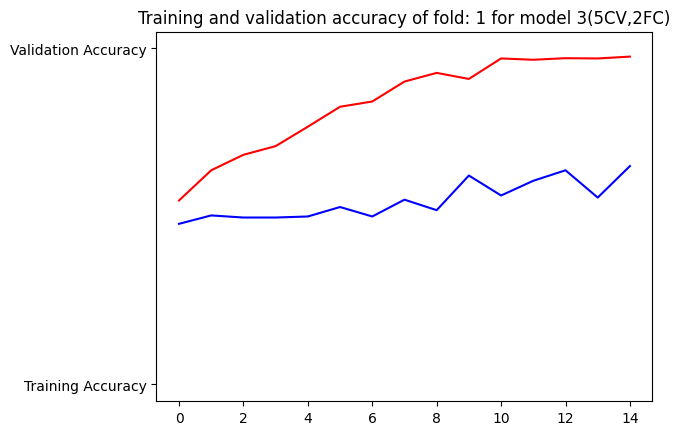

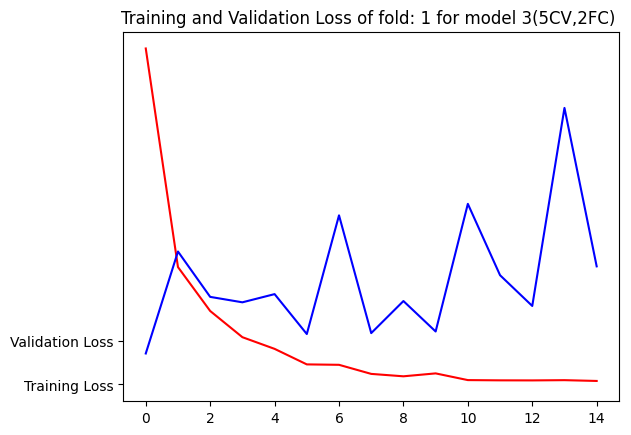

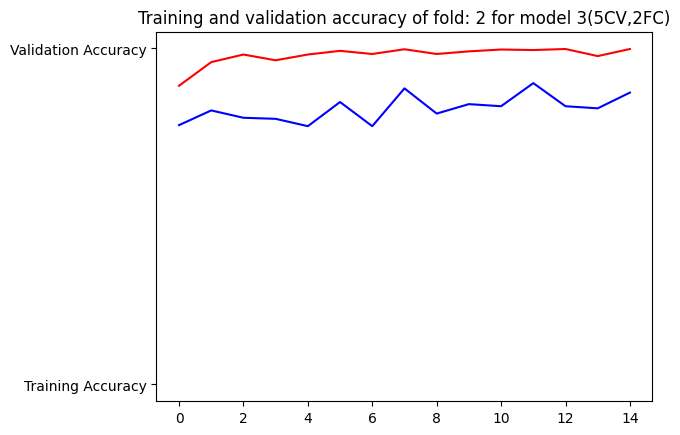

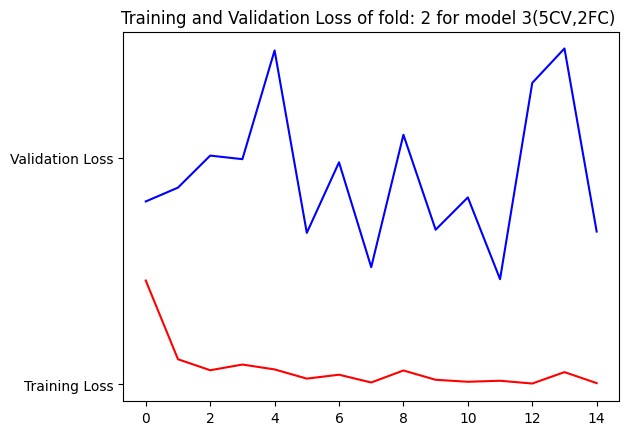

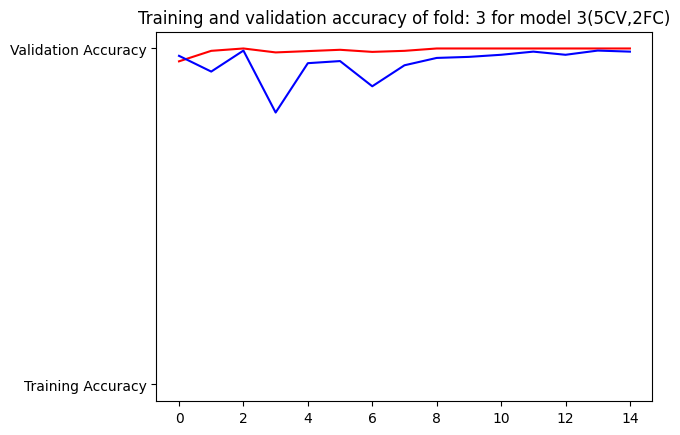

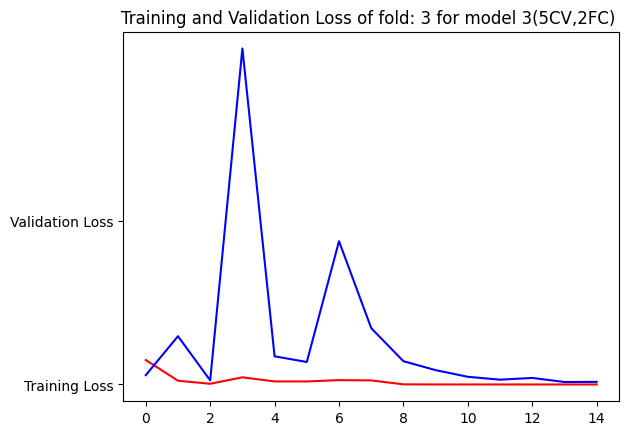

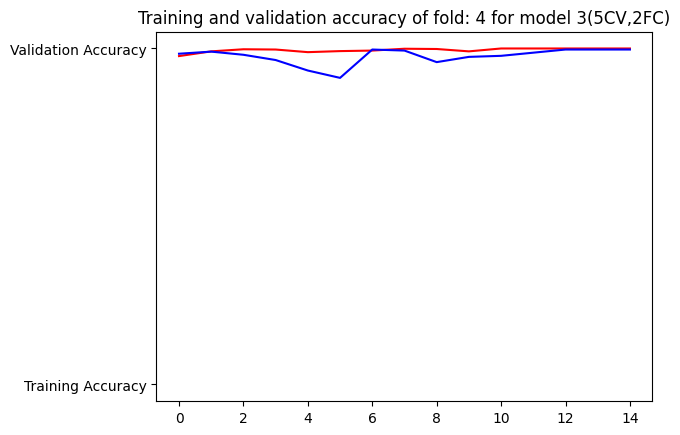

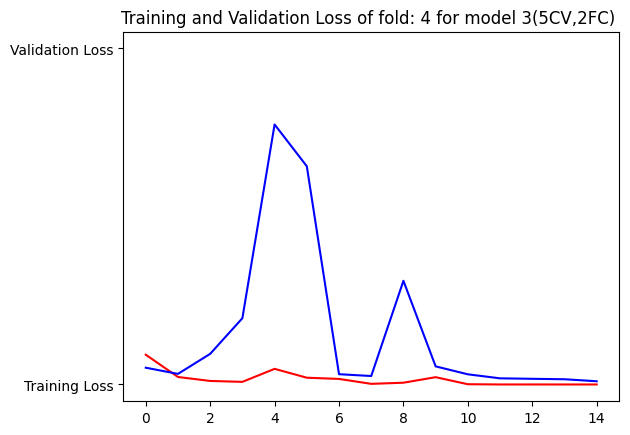

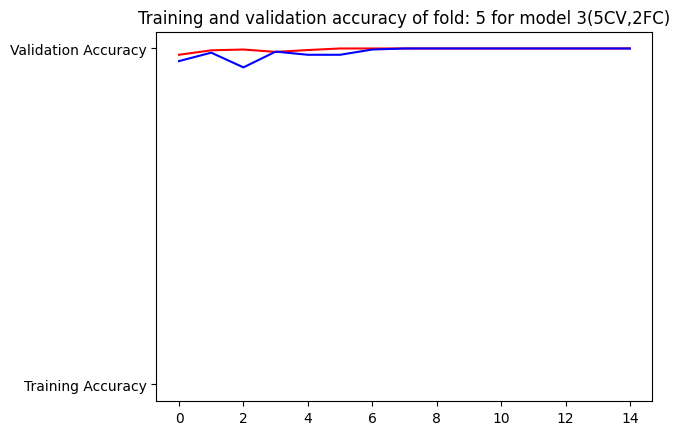

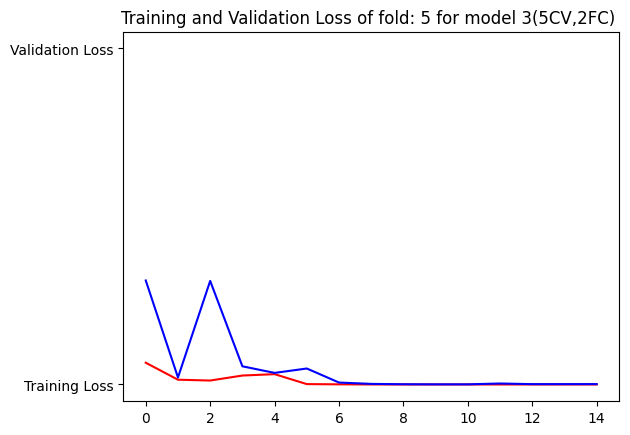

In [44]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for model3 with RMSprop optimizer and BinaryCrossentropy loss")
for i in range(5):
    loss=m3rms_models[i][1].history["loss"]
    val_loss=m3rms_models[i][1].history["val_loss"]
    acc=m3rms_models[i][1].history['accuracy']
    val_acc=m3rms_models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for model 3(5CV,2FC)')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model 3(5CV,2FC) ")
    plt.show()

In [45]:
from classification_models.keras import Classifiers
def resnet18rms():
    # for tensorflow.keras
    # from classification_models.tfkeras import Classifiers

    ResNet18, preprocess_input = Classifiers.get('resnet18')
    n_classes = 1

    base_model = ResNet18(input_shape=(200,200,3), include_top=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(n_classes, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                 loss="binary_crossentropy",
                 metrics=["accuracy"])
    model.summary()
    return model
resnet18rms=resnet18rms()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 200, 200, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_36 (ZeroPadding  (None, 206, 206, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

In [46]:
res18rms_models,res18rms_test_acc,res18rms_cm,res18rms_pred=implementationwith5FOLD(resnet18rms)

Results for fold 1
No file moved. Source empty!
No file moved. Source empty!
Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/15
20/20 [==============================] - 7s 288ms/step - loss: 0.6905 - accuracy: 0.5164 - val_loss: 2.2114 - val_accuracy: 0.4781
Epoch 2/15
20/20 [==============================] - 5s 264ms/step - loss: 0.6850 - accuracy: 0.5602 - val_loss: 0.8734 - val_accuracy: 0.4781
Epoch 3/15
20/20 [==============================] - 5s 273ms/step - loss: 0.6793 - accuracy: 0.5844 - val_loss: 0.7138 - val_accuracy: 0.5063
Epoch 4/15
20/20 [==============================] - 5s 268ms/step - loss: 0.6774 - accuracy: 0.5977 - val_loss: 0.6963 - val_accuracy: 0.4938
Epoch 5/15
20/20 [==============================] - 5s 267ms/step - loss: 0.6736 - accuracy: 0.6047 - val_loss: 0.6919 - val_accuracy: 0.5031
Epoch 6/15
20/20 [==============================] - 5s 270ms/step - loss: 0.6712 - accura

In [47]:
res18rms_test_acc

[0.57, 0.57, 0.5675, 0.5975, 0.5975]

Plotting the loss and accuracy graphs for ResNet18 with RMSprop optimizer and BinaryCrossentropy loss


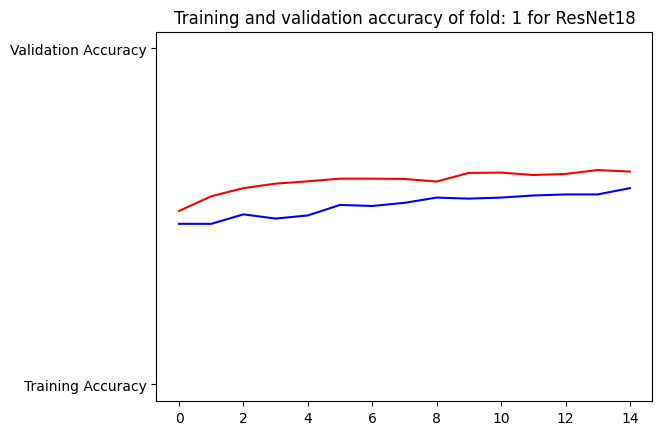

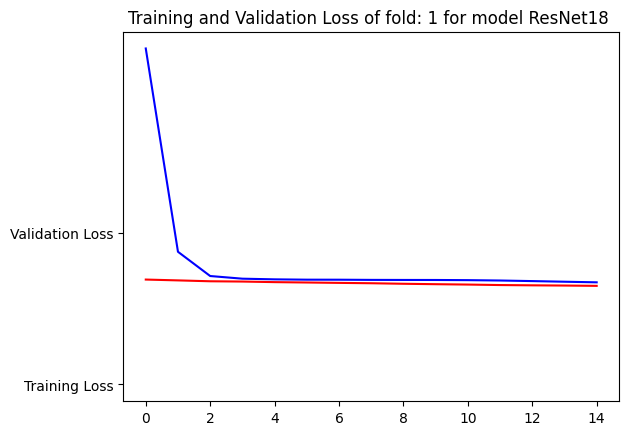

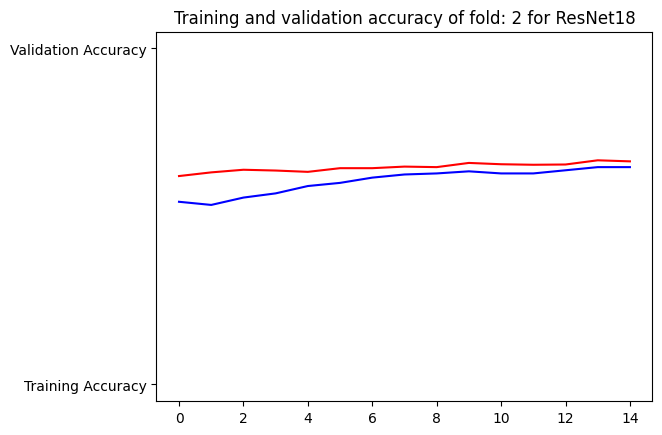

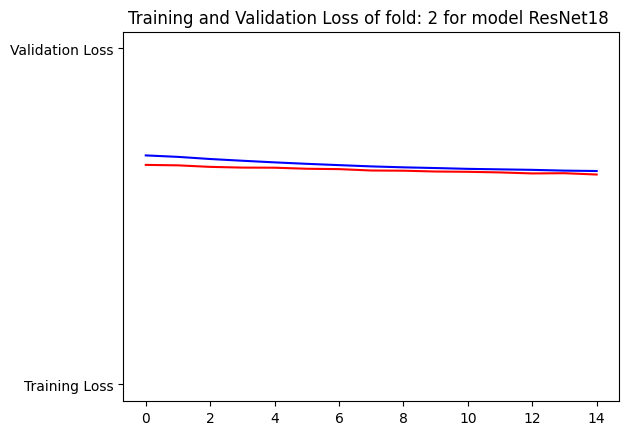

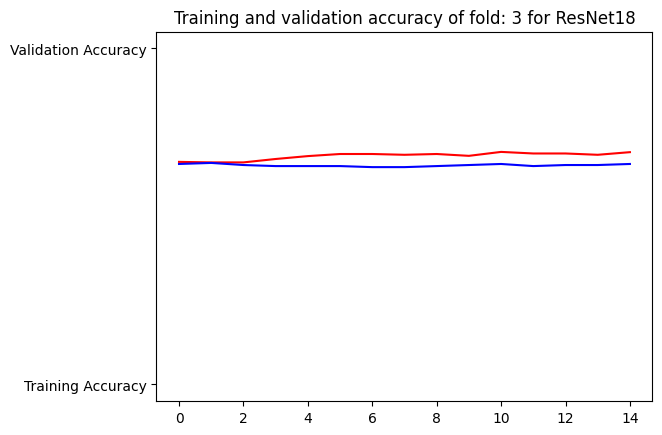

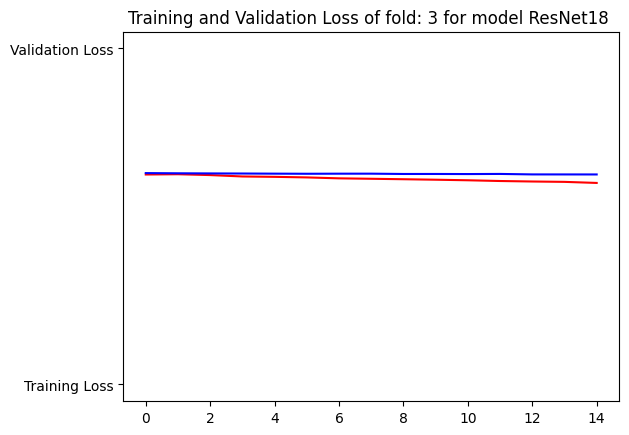

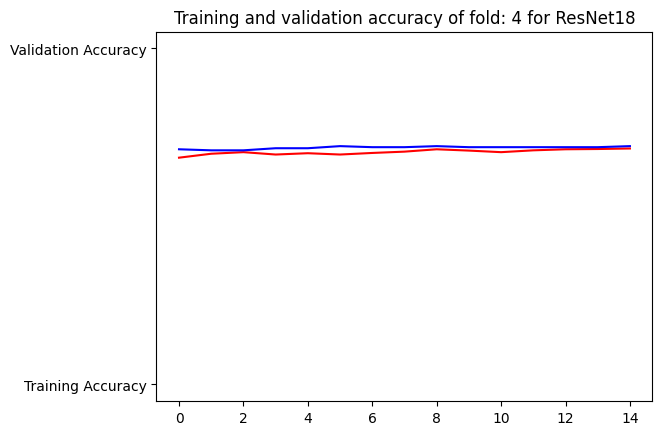

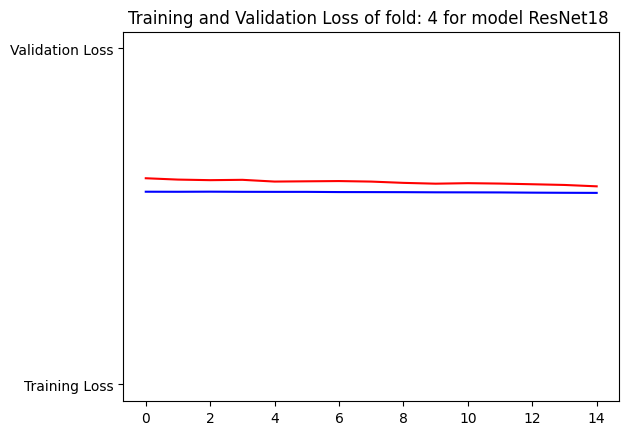

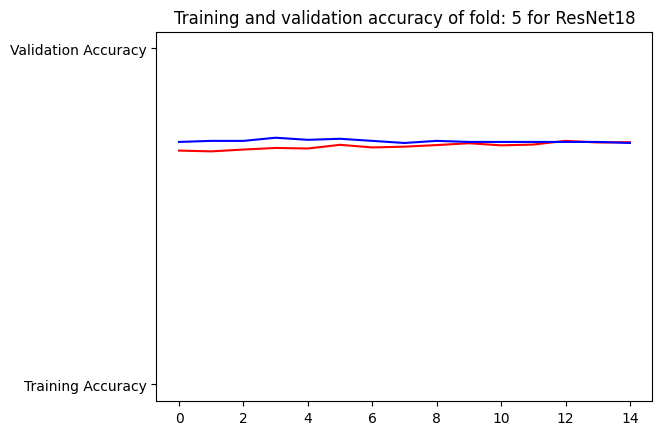

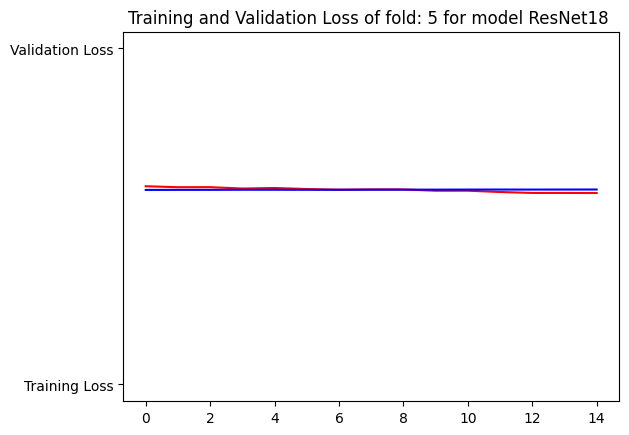

In [48]:
epochs=range(15)
print("Plotting the loss and accuracy graphs for ResNet18 with RMSprop optimizer and BinaryCrossentropy loss")
for i in range(5):
    loss=res18rms_models[i][1].history["loss"]
    val_loss=res18rms_models[i][1].history["val_loss"]
    acc=res18rms_models[i][1].history['accuracy']
    val_acc=res18rms_models[i][1].history['val_accuracy']
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title(f'Training and validation accuracy of fold: {i+1} for ResNet18')
    plt.show()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title(f"Training and Validation Loss of fold: {i+1} for model ResNet18 ")
    plt.show()

END OF THE PROJECT 
-ALPER ÇAKIR 
-2003603